In [4]:
from collections import defaultdict
from datetime import datetime
import dill
from itertools import permutations, combinations
import json
import math
from operator import itemgetter
import os
import pickle
import random
import re
import time

import numpy as np
import pandas as pd
import pandas as pd
import scipy

import little_mallet_wrapper as lmw

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
sns.set(style='ticks', font_scale=1.2)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Clean Data

In [8]:
# 2018

# for each paper -- run once, see which words are not in the dictionary,
# add valid missing words to dictionary
# run again to confirm caught appropriate missing words
# set finish_processing=True to write the cleaned file
def clean_paper_2018(papername, paper_path, finish_processing=False):
    full_filename = os.path.join(papers_path_root + "2018", papername)
    # checking if it is a file, cleaning part done in one place
    if os.path.isfile(full_filename):
        # open file for reading
        f = open(full_filename, 'r')
        file_contents = f.read()
        # for simplicity of running, make sure that after process once,
        # can re-process/ is idempotent
        
        # remove proceedings info from the file; from "Proceedings" through "ABSTRACT"
        cleaned_paper = file_contents
        if "Proceedings" in cleaned_paper: # TODO make sure case insensitive
            res = cleaned_paper.split("Proceedings")
            # keep title
            title = res[0]
            # remove authors, editors, proceedings info
            if "ABSTRACT" in cleaned_paper: # TODO make sure case insensitive
                res = res[1].split("ABSTRACT")
                if title:
                    cleaned_paper = title + res[1]
                else:
                    cleaned_paper = res[1]
        
        # remove acknowledgements
        if 'Acknowledgments' in cleaned_paper:       
            res = cleaned_paper.split('Acknowledgments')
            cleaned_paper = res[0]
        elif 'Acknowledgements'in cleaned_paper:
            res = cleaned_paper.split('Acknowledgements')
            cleaned_paper = res[0]
        elif 'ACKNOWLEDGEMENTS' in cleaned_paper:
            res = cleaned_paper.split('ACKNOWLEDGMENTS')
            cleaned_paper = res[0]
        elif 'ACKNOWLEDGEMENTS' in cleaned_paper:
            res = cleaned_paper.split('ACKNOWLEDGMENTS')
            cleaned_paper = res[0]
        
        # remove references, if the above didn't get them when removed acknowledgements
        if 'References' in cleaned_paper:       
            res = cleaned_paper.split('References')
            cleaned_paper = res[0]
        elif 'REFERENCES'in cleaned_paper:
            res = cleaned_paper.split('REFERENCES')
            cleaned_paper = res[0]
        
        # remove line breaks / i.e. rejoin hyphenated words; i.e., find "-\n"
        cleaned_paper = cleaned_paper.replace("-\n", "")
                
        # remove URLs; this is a quick and dirty way to do it
        cleaned_paper = re.sub(r'http\S+', '', cleaned_paper)
        
        # remove all non-alpha to take care of math; replace with '' for now
        rx = r'[^\w\n\s\-\/]+'
        #rx = r'[^a-zA-Z\n\s\-]'
        cleaned_paper = re.sub(rx, '', cleaned_paper)
        cleaned_paper = re.sub(r'\d', '', cleaned_paper)
        # TODO clean up with dict
        paper_as_tokens = cleaned_paper.split()
        # There is a more efficient way to do this...but I don't care
        missed_words = set()
        print("Words removed from: " + papername)
        for idx, token in enumerate(paper_as_tokens):
            if token.lower() not in dictionary and token.lower() not in missed_words:
                missed_words.add(token.lower())
                print(token.lower())
                # remove bad token
                paper_as_tokens[idx] = ""
        f.close()
    
    #print(cleaned_paper)
    # now overwrite the file
    if os.path.isfile(full_filename):
        print("Writing intermediate out file: {}".format(papername))
        f = open(full_filename, 'w')
        f.write(cleaned_paper)
        f.close()
    
    # set to true after completing manual cleaning
    if finish_processing and os.path.isfile(full_filename):
        cleaned_paper = ' '.join(paper_as_tokens)
        print("Writing final cleaned file: {}\n".format(papername))
        f = open(full_filename, 'w')
        f.write(cleaned_paper)
        f.close()


In [6]:
# 2019 -- copying and modifying above; refactoring this would just be more annoying

# for each paper -- run once, see which words are not in the dictionary,
# add valid missing words to dictionary
# run again to confirm caught appropriate missing words
# set finish_processing=True to write the cleaned file

license1 = """Permission to make digital or hard copies of all or part of this work for personal or
classroom use is granted without fee provided that copies are not made or distributed
for profit or commercial advantage and that copies bear this notice and the full citation
on the first page. Copyrights for components of this work owned by others than ACM
must be honored. Abstracting with credit is permitted. To copy otherwise, or republish,
to post on servers or to redistribute to lists, requires prior specific permission and/or a
fee. Request permissions from permissions@acm.org."""

proceedings = """FAT* ’19, January 29–31, 2019, Atlanta, GA, USA
© 2019 Association for Computing Machinery.
ACM ISBN 978-1-4503-6125-5/19/01. . . $15.00"""

def clean_paper_2019(papername, paper_path, finish_processing=False):
    full_filename = os.path.join(papers_path_root + "2019", papername)
    # checking if it is a file, cleaning part done in one place
    if os.path.isfile(full_filename):
        # open file for reading
        f = open(full_filename, 'r')
        file_contents = f.read()
        # for simplicity of running, make sure that after process once,
        # can re-process/ is idempotent
        
        # remove "ABSTRACT"
        cleaned_paper = file_contents
        if "ABSTRACT" in cleaned_paper: # TODO make sure case insensitive
            res = cleaned_paper.split("ABSTRACT")
            cleaned_paper = res[0] + " " + res[1]
        
        # remove license; this barely works / remove manually
        if license1 in cleaned_paper:
            res = cleaned_paper.split(license1)
            cleaned_paper = res[0] + res[1]
        
        # remove proceedings
        if proceedings in cleaned_paper:
            res = cleaned_paper.split(proceedings)
            cleaned_paper = res[0] + res[1]
        
        # remove acknowledgements
        if 'Acknowledgments' in cleaned_paper:       
            res = cleaned_paper.split('Acknowledgments')
            cleaned_paper = res[0]
        elif 'Acknowledgements'in cleaned_paper:
            res = cleaned_paper.split('Acknowledgements')
            cleaned_paper = res[0]
        elif 'ACKNOWLEDGMENTS' in cleaned_paper:
            res = cleaned_paper.split('ACKNOWLEDGMENTS')
            cleaned_paper = res[0]
        elif 'ACKNOWLEDGEMENTS' in cleaned_paper:
            res = cleaned_paper.split('ACKNOWLEDGEMENTS')
            cleaned_paper = res[0]
        
        # remove references, if the above didn't get them when removed acknowledgements
        if 'References' in cleaned_paper:       
            res = cleaned_paper.split('References')
            cleaned_paper = res[0]
        elif 'REFERENCES'in cleaned_paper:
            res = cleaned_paper.split('REFERENCES')
            cleaned_paper = res[0]
        
        # remove line breaks / i.e. rejoin hyphenated words; i.e., find "-\n"
        cleaned_paper = cleaned_paper.replace("-\n", "")
        # remove ccs
        cleaned_paper = cleaned_paper.replace("CCS", "")
                
        # remove URLs; this is a quick and dirty way to do it
        cleaned_paper = re.sub(r'http\S+', '', cleaned_paper)
        
        # remove all non-alpha to take care of math; replace with '' for now
        rx = r'[^\w\n\s\-\/]+'
        #rx = r'[^a-zA-Z\n\s\-]'
        cleaned_paper = re.sub(rx, '', cleaned_paper)
        cleaned_paper = re.sub(r'\d', '', cleaned_paper)
        
        # remove reference format
        if "ACM Reference Format" in cleaned_paper:
            res = cleaned_paper.split("ACM Reference Format")
            # this line doesn't work; spacing always different; remove manually
            #res2 = res[1].split("""ACM New York NY USA pages""")
            cleaned_paper = res[0] + " " + res[1]
        
        # TODO clean up with dict
        paper_as_tokens = cleaned_paper.split()
        # There is a more efficient way to do this...but I don't care
        # use a different loop for clarity, not efficiency certaintly
        manually_editing = False
        for idx, token in enumerate(paper_as_tokens):
            if token.lower() not in dictionary:
                # check if is a messed up word from rendering
                if token.lower() in messed_up_words:
                    paper_as_tokens[idx] = messed_up_words[token.lower()]
                    manually_editing = True
        
        if manually_editing:
            print("Editing mis-rendered words")
        
        missed_words = set()
        print("Words removed from: " + papername)
        for idx, token in enumerate(paper_as_tokens):
            if token.lower() not in dictionary and token.lower() not in missed_words:
                if token.lower() in garbage:
                    paper_as_tokens[idx] = ""
                else:
                    missed_words.add(token.lower())
                    print(token.lower())
                    # remove bad token
                    paper_as_tokens[idx] = ""
        
        f.close()
        
        #print(cleaned_paper)
    # now overwrite the file
    if os.path.isfile(full_filename):
        print("Writing intermediate out file: {}".format(papername))
        f = open(full_filename, 'w')
        f.write(cleaned_paper)
        f.close()
    
    # set to true after completing manual cleaning
    if finish_processing and os.path.isfile(full_filename):
        cleaned_paper = ' '.join(paper_as_tokens)
        print("Writing final cleaned file: {}\n".format(papername))
        f = open(full_filename, 'w')
        f.write(cleaned_paper)
        f.close()



In [9]:
# 2020 -- copying and modifying above; refactoring this would just be more annoying

# for each paper -- run once, see which words are not in the dictionary,
# add valid missing words to dictionary
# run again to confirm caught appropriate missing words
# set finish_processing=True to write the cleaned file

def clean_paper_2020(papername, paper_path, finish_processing=False):
    full_filename = os.path.join(papers_path_root + "2020", papername)
    # checking if it is a file, cleaning part done in one place
    if os.path.isfile(full_filename):
        # open file for reading
        f = open(full_filename, 'r')
        file_contents = f.read()
        # for simplicity of running, make sure that after process once,
        # can re-process/ is idempotent
        
        # remove "ABSTRACT"
        cleaned_paper = file_contents
        if "ABSTRACT" in cleaned_paper: # TODO make sure case insensitive
            res = cleaned_paper.split("ABSTRACT")
            cleaned_paper = res[0] + " " + res[1]
        
        # remove license; this barely works / remove manually
        if license1 in cleaned_paper:
            res = cleaned_paper.split(license1)
            cleaned_paper = res[0] + res[1]
        
        # remove proceedings
        if proceedings in cleaned_paper:
            res = cleaned_paper.split(proceedings)
            cleaned_paper = res[0] + res[1]
        
        # remove acknowledgements
        if 'Acknowledgments' in cleaned_paper:       
            res = cleaned_paper.split('Acknowledgments')
            cleaned_paper = res[0]
        elif 'Acknowledgements'in cleaned_paper:
            res = cleaned_paper.split('Acknowledgements')
            cleaned_paper = res[0]
        elif 'ACKNOWLEDGMENTS' in cleaned_paper:
            res = cleaned_paper.split('ACKNOWLEDGMENTS')
            cleaned_paper = res[0]
        elif 'ACKNOWLEDGEMENTS' in cleaned_paper:
            res = cleaned_paper.split('ACKNOWLEDGEMENTS')
            cleaned_paper = res[0]
        
        # remove references, if the above didn't get them when removed acknowledgements
        if 'References' in cleaned_paper:       
            res = cleaned_paper.split('References')
            cleaned_paper = res[0]
        elif 'REFERENCES'in cleaned_paper:
            res = cleaned_paper.split('REFERENCES')
            cleaned_paper = res[0]
        
        # remove line breaks / i.e. rejoin hyphenated words; i.e., find "-\n"
        cleaned_paper = cleaned_paper.replace("-\n", "")
        # remove ccs
        cleaned_paper = cleaned_paper.replace("CCS", "")
                
        # remove URLs; this is a quick and dirty way to do it
        cleaned_paper = re.sub(r'http\S+', '', cleaned_paper)
        
        # remove all non-alpha to take care of math; replace with '' for now
        rx = r'[^\w\n\s\-\/]+'
        #rx = r'[^a-zA-Z\n\s\-]'
        cleaned_paper = re.sub(rx, '', cleaned_paper)
        cleaned_paper = re.sub(r'\d', '', cleaned_paper)
        
        # TODO clean up with dict
        paper_as_tokens = cleaned_paper.split()
        # There is a more efficient way to do this...but I don't care
        # use a different loop for clarity, not efficiency certaintly
        manually_editing = False
        for idx, token in enumerate(paper_as_tokens):
            if token.lower() not in dictionary:
                # check if is a messed up word from rendering
                if token.lower() in messed_up_words:
                    paper_as_tokens[idx] = messed_up_words[token.lower()]
                    manually_editing = True
        
        if manually_editing:
            print("Editing mis-rendered words")
        
        missed_words = set()
        print("Words removed from: " + papername)
        for idx, token in enumerate(paper_as_tokens):
            if token.lower() not in dictionary and token.lower() not in missed_words:
                if token.lower() in garbage:
                    paper_as_tokens[idx] = ""
                else:
                    missed_words.add(token.lower())
                    print(token.lower())
                    # remove bad token
                    paper_as_tokens[idx] = ""
        
        f.close()
        
        #print(cleaned_paper)
    # now overwrite the file
    if os.path.isfile(full_filename):
        print("Writing intermediate out file: {}".format(papername))
        f = open(full_filename, 'w')
        f.write(cleaned_paper)
        f.close()
    
    # set to true after completing manual cleaning
    if finish_processing and os.path.isfile(full_filename):
        cleaned_paper = ' '.join(paper_as_tokens)
        print("Writing final cleaned file: {}\n".format(papername))
        f = open(full_filename, 'w')
        f.write(cleaned_paper)
        f.close()



In [10]:
# 2021 -- copying and modifying above; refactoring this would just be more annoying

# for each paper -- run once, see which words are not in the dictionary,
# add valid missing words to dictionary
# run again to confirm caught appropriate missing words
# set finish_processing=True to write the cleaned file

def clean_paper_2021(papername, paper_path, finish_processing=False):
    full_filename = os.path.join(papers_path_root + "2021", papername)
    # checking if it is a file, cleaning part done in one place
    if os.path.isfile(full_filename):
        # open file for reading
        f = open(full_filename, 'r')
        file_contents = f.read()
        # for simplicity of running, make sure that after process once,
        # can re-process/ is idempotent
        
        # remove "ABSTRACT"
        cleaned_paper = file_contents
        if "ABSTRACT" in cleaned_paper: # TODO make sure case insensitive
            res = cleaned_paper.split("ABSTRACT")
            cleaned_paper = res[0] + " " + res[1]
        
        # remove license; this barely works / remove manually
        if license1 in cleaned_paper:
            res = cleaned_paper.split(license1)
            cleaned_paper = res[0] + res[1]
        
        # remove proceedings
        if proceedings in cleaned_paper:
            res = cleaned_paper.split(proceedings)
            cleaned_paper = res[0] + res[1]
        
        # remove acknowledgements
        if 'Acknowledgments' in cleaned_paper:       
            res = cleaned_paper.split('Acknowledgments')
            cleaned_paper = res[0]
        elif 'Acknowledgements'in cleaned_paper:
            res = cleaned_paper.split('Acknowledgements')
            cleaned_paper = res[0]
        elif 'ACKNOWLEDGMENTS' in cleaned_paper:
            res = cleaned_paper.split('ACKNOWLEDGMENTS')
            cleaned_paper = res[0]
        elif 'ACKNOWLEDGEMENTS' in cleaned_paper:
            res = cleaned_paper.split('ACKNOWLEDGEMENTS')
            cleaned_paper = res[0]
        
        # remove references, if the above didn't get them when removed acknowledgements
        if 'References' in cleaned_paper:       
            res = cleaned_paper.split('References')
            cleaned_paper = res[0]
        elif 'REFERENCES'in cleaned_paper:
            res = cleaned_paper.split('REFERENCES')
            cleaned_paper = res[0]
        
        # remove line breaks / i.e. rejoin hyphenated words; i.e., find "-\n"
        cleaned_paper = cleaned_paper.replace("-\n", "")
        # remove ccs
        cleaned_paper = cleaned_paper.replace("CCS", "")
                
        # remove URLs; this is a quick and dirty way to do it
        cleaned_paper = re.sub(r'http\S+', '', cleaned_paper)
        
        # remove all non-alpha to take care of math; replace with '' for now
        rx = r'[^\w\n\s\-\/]+'
        #rx = r'[^a-zA-Z\n\s\-]'
        cleaned_paper = re.sub(rx, '', cleaned_paper)
        cleaned_paper = re.sub(r'\d', '', cleaned_paper)
        
        # TODO clean up with dict
        paper_as_tokens = cleaned_paper.split()
        # There is a more efficient way to do this...but I don't care
        # use a different loop for clarity, not efficiency certaintly
        manually_editing = False
        for idx, token in enumerate(paper_as_tokens):
            if token.lower() not in dictionary:
                # check if is a messed up word from rendering
                if token.lower() in messed_up_words:
                    paper_as_tokens[idx] = messed_up_words[token.lower()]
                    manually_editing = True
        
        if manually_editing:
            print("Editing mis-rendered words")
        
        missed_words = set()
        print("Words removed from: " + papername)
        for idx, token in enumerate(paper_as_tokens):
            if token.lower() not in dictionary and token.lower() not in missed_words:
                if token.lower() in garbage:
                    paper_as_tokens[idx] = ""
                else:
                    missed_words.add(token.lower())
                    print(token.lower())
                    # remove bad token
                    paper_as_tokens[idx] = ""
        
        f.close()
        
        #print(cleaned_paper)
    # now overwrite the file
    if os.path.isfile(full_filename):
        print("Writing intermediate out file: {}".format(papername))
        f = open(full_filename, 'w')
        f.write(cleaned_paper)
        f.close()
    
    # set to true after completing manual cleaning
    if finish_processing and os.path.isfile(full_filename):
        cleaned_paper = ' '.join(paper_as_tokens)
        print("Writing final cleaned file: {}\n".format(papername))
        f = open(full_filename, 'w')
        f.write(cleaned_paper)
        f.close()

In [11]:
def clean_abstract(papername, paper_path, year, finish_processing=False):
    full_filename = os.path.join(paper_path + year + "_abstracts", papername)
    # checking if it is a file, cleaning part done in one place
    if os.path.isfile(full_filename):
        # open file for reading
        f = open(full_filename, 'r')
        file_contents = f.read()
        # for simplicity of running, make sure that after process once,
        # can re-process/ is idempotent
        
        cleaned_paper = file_contents

        # remove line breaks / i.e. rejoin hyphenated words; i.e., find "-\n"
        cleaned_paper = cleaned_paper.replace("-\n", "")
        # remove ccs
        cleaned_paper = cleaned_paper.replace("CCS", "")
                
        # remove URLs; this is a quick and dirty way to do it
        cleaned_paper = re.sub(r'http\S+', '', cleaned_paper)
        
        # remove all non-alpha to take care of math; replace with '' for now
        rx = r'[^\w\n\s\-\/]+'
        #rx = r'[^a-zA-Z\n\s\-]'
        cleaned_paper = re.sub(rx, '', cleaned_paper)
        cleaned_paper = re.sub(r'\d', '', cleaned_paper)
        
        # TODO clean up with dict
        paper_as_tokens = cleaned_paper.split()
        # There is a more efficient way to do this...but I don't care
        # use a different loop for clarity, not efficiency certaintly
        manually_editing = False
        for idx, token in enumerate(paper_as_tokens):
            if token.lower() not in dictionary:
                # check if is a messed up word from rendering
                if token.lower() in messed_up_words:
                    paper_as_tokens[idx] = messed_up_words[token.lower()]
                    manually_editing = True
        
        if manually_editing:
            print("Editing mis-rendered words")
        
        missed_words = set()
        print("Words removed from: " + papername)
        for idx, token in enumerate(paper_as_tokens):
            if token.lower() not in dictionary and token.lower() not in missed_words:
                if token.lower() in garbage:
                    paper_as_tokens[idx] = ""
                else:
                    missed_words.add(token.lower())
                    print(token.lower())
                    # remove bad token
                    paper_as_tokens[idx] = ""
        
        f.close()
        
        #print(cleaned_paper)
    # now overwrite the file
    if os.path.isfile(full_filename):
        print("Writing intermediate out file: {}".format(papername))
        f = open(full_filename, 'w')
        f.write(cleaned_paper)
        f.close()
    
    # set to true after completing manual cleaning
    if finish_processing and os.path.isfile(full_filename):
        cleaned_paper = ' '.join(paper_as_tokens)
        print("Writing final cleaned file: {}\n".format(papername))
        f = open(full_filename, 'w')
        f.write(cleaned_paper)
        f.close()

In [12]:
# load up dictionaries

papers_path_root = '../../Data/TXTs/CleanedPapers_LDA/'

dictionary = set()

with open(papers_path_root + "dictionary.txt", encoding="utf-8") as f:
    for line in f:
        word = line.strip()
        if word and "#" not in word:
            dictionary.add(word)
# this sucks but some of the PDFs don't render f's and y's correctly
# this is to clean up commonly messed up words, and sometimes also i
# when it's in close proximity to f or y
messed_up_words = {
                    'aair': 'affair',
                    'aairs': 'affairs',
                    'afecting':'affecting',
                    'afect':'affect',
                    'afects':'affects',
                    'ags': 'flags',
                    'ainity': 'affinity',
                    'articial': 'artificial',
                    'aect': 'affect',
                    'aected': 'affected',
                    'aects': 'affects',
                    'afrmative': 'affirmative',
                    'aliated': 'affiliated',
                    'amplied': 'amplified',
                    'amplies': 'amplifies',
                    'ampliied': 'amplified',
                    'aord': 'afford',
                    'aords': 'affords',
                    'aorded': 'afforded',
                    'application-specic': 'application-specific',
                    'application-speciic': 'application-specific',
                    'artice' : 'artifice',
                    'artices' : 'artifices',
                    'artiicial': 'artificial',
                    'articially': 'artificially',
                    'auent': 'affluent',
                    'avor': 'flavor',
                    'aws': 'flaws',
                    'beneted':'benefitted',
                    'benet':'benefit',
                    'beneit': 'benefit',
                    'beneft': 'benefit',
                    'benefts': 'benefits',
                    'benets':'benefits',
                    'benecial':'beneficial',
                    'benefcial': 'beneficial',
                    'briey': 'briefly',
                    'briely':'briefly',
                    'buer': 'buffer',
                    'career-specic': 'career-specific',
                    'case-speciic': 'case-specific',
                    'certied':'certified',
                    'certicate': 'certificate',
                    'claried': 'clarified',
                    'classication': 'classification',
                    'classiication': 'classification',
                    'classications': 'classifications',
                    'classiiers': 'classifiers',
                    'classies': 'classifies',
                    'classied': 'classified',
                    'classier': 'classifier',
                    'classiier':'classifier',
                    'classiers': 'classifiers',
                    'codied': 'codified',
                    'coecient':'coefficient',
                    'coecients':'coefficients',
                    'coeicient':'coefficient',
                    'coeicients':'coefficients',
                    'conicting': 'conflicting',
                    'conict': 'conflict',
                    'conicts': 'conflicts',
                    'condence': 'confidence',
                    'confdent': 'confident',
                    'condently':'confidently',
                    'condence-interval': 'confidence-interval',
                    'conidence': 'confidence',
                    'confrm': 'confirm',
                    'conrm': 'confirm',
                    'conrmation': 'confirmation',
                    'conirming': 'confirming',
                    'conrming': 'confirming',
                    'conrmed': 'confirmed',
                    'conirmed': 'confirmed',
                    'conguration': 'configuration',
                    'congurations': 'configurations',
                    'condentiality': 'confidentiality',
                    'cost-bene': 'cost-benefit',
                    'cost-eective': 'cost-effective',
                    'cost-efective': 'cost-effective',
                    'datacation': 'datafication',
                    'decient': 'deficient',
                    'deciencies': 'deficiencies',
                    'dene': 'define',
                    'defne': 'define',
                    'delity':'fidelity',
                    'dened': 'defined',
                    'denes': 'defines',
                    'deined': 'defined',
                    'dening': 'defining',
                    'deining': 'defining',
                    'defnitely': 'definitely',
                    'denitively': 'definitively',
                    'defning': 'defining',
                    'denition': 'definition',
                    'deinition': 'definition',
                    'defnition': 'definition',
                    'denitions': 'definitions',
                    'deinition': 'definitions',
                    'denitive': 'definitive',
                    'dicult':'difficult',
                    'difcult': 'difficult',
                    'difculties': 'difficulties',
                    'diculty':'difficulty',
                    'difculty': 'difficulty',
                    'dier': 'differ',
                    'diers': 'differs',
                    'dierence': 'difference',
                    'diference': 'difference',
                    'dierences': 'differences',
                    'diferences':'differences',
                    'dierent': 'different',
                    'difer':'differ',
                    'diering': 'differing',
                    'diferent': 'different',
                    'dierently': 'differently',
                    'diferently': 'differently',
                    'dierentiates':'differentiates',
                    'dierentiation': 'differentiation',
                    'dierentiating':'differentiating',
                    'dierentiable': 'differentiable',
                    'dierential': 'differential',
                    'dierentially': 'differentially',
                    'diversied':'diversified',
                    'diversication':'diversification',
                    'domain-specic': 'domain-specific',
                    'efuent': 'effluent',
                    'eluent': 'effluent',
                    'euent': 'effluent',
                    'euent-related':'effluent-related',
                    'eect':'effect',
                    'efect': 'effect',
                    'ecting': 'effecting',
                    'eective':'effective',
                    'efective': 'effective',
                    'eectively':'effectively',
                    'efectiveness':'effectiveness',
                    'eectiveness':'effectiveness',
                    'efectively':'effectively',
                    'ecacy': 'efficacy',
                    'eects':'effects',
                    'efects': 'effects',
                    'ecient': 'efficient',
                    'eicient':'efficient',
                    'eiciently':'efficiently',
                    'efciently': 'efficiently',
                    'eciently': 'efficiently',
                    'eciency':'efficiency',
                    'elds': "fields",
                    'elded': 'fielded',
                    'eort': 'effort',
                    'eorts': 'efforts',
                    'efort': 'effort',
                    'eforts': 'efforts',
                    'eort-based': 'effort-based',
                    'exible': 'flexible',
                    'fction': 'fiction',
                    'fnd': 'find',
                    'fnds': 'finds',
                    'fnding': 'finding',
                    'fndings': 'findings',
                    'fnancial': 'financial',
                    'fnished': 'finished',
                    'fnishing': 'finishing',
                    'fle': 'file',
                    'fles': 'files',
                    'for-proft': 'for-profit',
                    'frst': 'first',
                    'ftting': 'fitting',
                    'fuency': 'fluency',
                    'fuent': 'fluent',
                    'fve': 'five',
                    'group-specic':'group-specific',
                    'gure': 'figure',
                    'gures': 'figures',
                    'high-conidence':'high-confidence',
                    'high-delity':'high-fidelity',
                    'identication': 'identification',
                    'identied': 'identified',
                    'identifed': 'identified',
                    'identiied': 'identified',
                    'identies': 'identifies',
                    'identifes': 'identifies',
                    'identifable': 'identifiable',
                    'identiably': 'identifiably',
                    'indierence': 'indifference',
                    'ierce':'fierce',
                    'igure': 'figure',
                    'inal': 'final',
                    'inancial':'financial',
                    'indenitely': 'indefinitely',
                    'inefective': 'ineffective',
                    'infuenced': 'influenced',
                    'inuences': 'influences',
                    'inluenced': 'influenced',
                    'inluences': 'influences',
                    'inluential': 'influential',
                    'ilter':'filter',
                    'iltered':'filtered',
                    'ilters':'filters',
                    'iltering':'filtering',
                    'lter':'filter',
                    'ltered':'filtered',
                    'lters':'filters',
                    'ltering':'filtering',
                    'ind': 'find',
                    'indierent': 'indifferent',
                    'inecient': 'inefficient',
                    'inds': 'finds',
                    'nds':'finds',
                    'inding':'finding',
                    'indings':'findings',
                    'ine-grained':'fine-grained',
                    'innitely': 'infinitely',
                    'innite-time-horizon': 'infinite-time-horizon',
                    'innity': 'infinity',
                    'innitesimally':'infinitesimally',
                    'inluence':'influence',
                    'inuencing': 'influencing',
                    'inuential': 'influential',
                    'inuenced': 'influenced',
                    'innite': 'infinite',
                    'insignicant': 'insignificant',
                    'insigniicant': 'insignificant',
                    'insucient': 'insufficient',
                    'insuicient': 'insufficient',
                    'inuence': 'influence',
                    'irst':'first',
                    'ixed': "fixed",
                    'jasano': 'jasanoff',
                    'justication': 'justification',
                    'justications': 'justifications',
                    'justied': 'justified',
                    'justifed': 'justified',
                    'low-conidence':'low-confidence',
                    'lled': 'filled',
                    'lling': 'filling',
                    'mis-specied': 'mis-specified',
                    'misclassiied': 'misclassified',
                    'misclassication': 'misclassification',
                    'misclassiications': 'misclassifications',
                    'misclassications': 'misclassifications',
                    'modied':'modified',
                    'modies': 'modifies',
                    'modication': 'modification',
                    'modications': 'modifications',
                    'nancial':'financial',
                    'nancially': 'financially',
                    'nal': 'final',
                    'inally':'finally',
                    'nally': 'finally',
                    'nding': "ending",
                    'ndings': "endings",
                    'ne-grained': 'fine-grained',
                    'ne-tune': 'fine-tune',
                    'ne-tuned': 'fine-tuned',
                    'ne-tuning':'fine-tuning',
                    'nite': 'finite',
                    'notication': 'notification',
                    'notications': 'notifications',
                    'non-quantiable':'non-quantifiable',
                    'non-proft': 'non-profit',
                    'non-prots': 'non-profits',
                    'ocer':'officer',
                    'ocers':'officers',
                    'ocial': 'official',
                    'oer': 'offer',
                    'ofer': 'offer',
                    'ofered': 'offered',
                    'ofers': 'offers',
                    'oers': 'offers',
                    'oered':'offered',
                    'oering': 'offering',
                    'ofering': 'offering',
                    'oender': 'offender',
                    'oenders': 'offenders',
                    'oense': 'offense',
                    'offense': 'offense',
                    'oenses': 'offenses',
                    'oense': 'offenses',
                    'ofensive': 'offensive',
                    'ofensiveness': 'offensiveness',
                    'optimalitydened': 'optimality-defined',
                    'ospring': 'offspring',
                    'osprings': 'offsprings',
                    'over-inuence': 'over-influence',
                    'over-tting':'over-fitting',
                    'overly-simpliied': 'overly-simplified',
                    'ower': 'flower',
                    'owers': 'flowers',
                    'payo': 'payoff',
                    'payos': 'payoffs',
                    'payo-maximizing': 'payoff-maximizing',
                    'payo/reward': 'payoff/reward',
                    'pre-dened': 'pre-defined',
                    'proiciency': 'proficiency',
                    'proile': 'profile',
                    'proled': 'profiled',
                    'proling': 'profiling',
                    'prot':'profit',
                    'prots':'profits',
                    'prot-maximizing':'profit-maximizing',
                    'protable':'profitable',
                    'protably':'profitably',
                    'qualication':'qualification',
                    'qualications':'qualifications',
                    'quantication': 'quantification',
                    'quantied': 'quantified',
                    'quanties': 'quantifies',
                    'quantiable':'quantifiable',
                    'qualied': 'qualified',
                    'ramications': 'ramifications',
                    'redened': 'redefined',
                    'reect':'reflects',
                    'reected':'reflected',
                    'reecting':'reflecting',
                    'reection': 'reflection',
                    'rectication': 'rectification',
                    'reects':'reflects',
                    'refects': 'reflects',
                    'reective': 'reflective',
                    'reexive': 'reflexive',
                    'reward/payo': 'reward/payoff',
                    'rm': 'term',
                    'rstly': 'firstly',
                    'satisies': 'satisfies',
                    'satises':'satisfies',
                    'satisied': 'satisfied',
                    'satised': 'satisfied',
                    'scientically': 'scientifically',
                    'scientic': 'scientific',
                    'selfe': 'selfie',
                    'shue': 'shuffle',
                    'shued': 'shuffled',
                    'shues': 'shuffles',
                    'shuing': 'shuffling',
                    'signicance': 'significance',
                    'signiicance': 'significance',
                    'signicant': 'significant',
                    'signiicant': 'significant',
                    'signifcant': 'significant',
                    'signies': 'signifies',
                    'signicantly': 'significantly',
                    'signifcantly':'significantly',
                    'signiicantly': 'significantly',
                    'simplied':'simplified',
                    'simplies': 'simplifies',
                    'simplifed': 'simplified',
                    'simplication': 'simplification',
                    'specic': 'specific',
                    'speciic': 'specific',
                    'specifc': 'specific',
                    'specied': 'specified',
                    'specicity': 'specificity',
                    'speciically': 'specifically',
                    'specically': 'specifically',
                    'specifcally': 'specifically',
                    'specicities':'specificities',
                    'specication':'specification',
                    'specications':'specifications',
                    'stratied': 'stratified',
                    'sub-elds': 'sub-fields',
                    'subelds': 'subfields',
                    'suce': 'suffice',
                    'suces': 'suffices',
                    'suer': 'suffer',
                    'suers': 'suffers',
                    'suering': 'suffering',
                    'sufce': 'suffice',
                    'sucient': 'sufficient',
                    'suicient': 'sufficient',
                    'suficient': 'sufficient',
                    'sufcient': 'sufficient',
                    'suciently':'sufficiently',
                    'sufciently': 'sufficiently',
                    'suiciently': 'sufficiently',
                    'sufer': 'suffer',
                    'stratication': 'stratification',
                    'stratiied': 'stratified',
                    'trac': 'traffic',
                    'trade-o':'trade-off',
                    'tradeof': 'tradeoff',
                    'trade-os':'trade-offs',
                    'tradeo':'tradeoff',
                    'tradeos':'trade-offs',
                    'tted': 'fitted',
                    'tting': 'fitting',
                    'uctuations': 'fluctuations',
                    'undened': 'undefined',
                    'under-qualied': 'under-qualified',
                    'unqualied': 'unqualified',
                    'unied': 'unified',
                    'uniied': 'unified',
                    'unaected':'unaffected',
                    'unafected': 'unaffected',
                    'unsatisable': 'unsatisfiable',
                    'unshued': 'unshuffled',
                    'user-specic': 'user-specific',
                    'veriied': 'verified',
                    'veriication': 'verification',
                    'well-dened': 'well-defined',
                    'well-deined': 'well-defined',
                    'with-conidence': 'with-confidence',
                    'without-conidence': 'without-confidence',
                    'xed': 'fixed',
                    'xing': 'fixing'
                  }

garbage = {'f', 'rt', 'ic', 'h', 'hh', '-', '/', 'φ', 'dq','js','cs','nmf','vui','nvui','µi','rui',
    'xu','yi','uiκ','κ','iu','ht','uu','ttt','sntv','sisj','τ','wv','plv','tt','ct','-p','lu','xi','xtu','k',
    'ś','σi','j','βi','wherec','cm','β','βn','w','itemsw','iew', 'aren', 'arem', 'anm','avh','hmt','hasv',
    'ci','iem','gmi','gvi','discvi','χ','discc','cici','fi','discci','α','vj','disccj','wα','vti','inwα',
    'andv','χmax','lbi','lbj','ubj','cj','gς','cti','gv','/m','δ','leastmi/','ln/δ','/αmi','leastk','thanmi/',
    'belowmi/','αmi','valuemi/','valuemi','beyondmi/','λ','λti','v/g','oti','minvti','hti','ˆλti','ˆl','ϵδ','λmin',
    'λmax','lng/δ','/ηϵ','tmax','η','ˆλi','λi','ϵ','dtv','dgv','wαd','ηϵ','pof','pofα','w/χ','/pofα','/pof',
    '/mi','µ','µg','civi/mi','vi/mi','vj/mj','mα','mm','m/m','ys','ici','rn','ey','og','jo','yc','eo','ite',
    'fil','ak','ftw','e_','iti','ia','iro','_t','dj','rio','r_','sig','pp' ,'tanh','exp','sдy','πдyy','π',
    'cu','cy','д','yy','sдyy','xri','дд','yyi','xr','ei','gru','eti','tprдy','дy','gapдy','πдy','not-q','λf','iℓx',
    'af','anduf','useuτ','bτ','toufτ','bfτ','fτ','uτ','aτ','px','ττ','tn','τn','fдl','dl','dx','clτ','cдx','κca',
    'uf','ux','cx','ℓx','ℓxℓx','uτ','groupд','bдf','groupb','lд','fд','lτ','maxcl','maxαl','gτ','bдτ','clℓxτ',
    'σ','byti','ϕ','letai','γ','дai','eqal','дa','cdд','ati','bsi','cgi','bxi','cyi','letn','letz','zz','zi',
    'meanm','rninj','σς','ϕx','φx','xt','sβi','tds','limt','pq','σσ','prt','prσ','prд','prsi','pδ','uqδ','prti',
    'sд','pqδ','pqδpqδ','qδ','pq/ur', 'eq','zj','xth','zxj','ui','θi','λθ','θ','ϵi','дxyh','functionд','xy',
    'andh','xyh','hxah','dh','zy','pxy','exy','дwy','дxy','pyy','zhd','zπ','vz','hπ','hx','zw', 'ε','τ/ε',
    'lett','bt','ε/τ','ℓj','uj','ft','εm','rp','sλx','ψi','ℓu','isλ','λrp','дλ','exℑ','ℓi','cov','τsr','τtpr',
    'τfpr','γq','γsrf','τq','xp','pn','zn','iy','ifz','prℑ','toℑ','ifℑ','qℑi','qℑ','qℑf','wrt','qi','qj',
    'ef','xx','sim','xa','xb','fxxn','eterm','ee','ψ','ψδ','δδ', 'дx','αf','дp','βf','дdp','fpdд','ℓ','hxi', 'µw',
    'ˆδw','ˆδ','µu','µa','µb', 'nw','mxi','eε','vε','mx','dy','αi','pnw','iyi','ηxk','pxi','qti','xk', 'ixi','xm',
    'çx','pxdb','ckb','bx','ppxda','cka','πt','τt','βt','дj','βg','βv','βa','βb','πa','πb','ϵat','ϵbt',
    'bϵbt','πtπt','fβt','πtt','dπt','dπ','δiπei','δi','δk','δiδi','πei','πbaa','дau/дau','/α','πta','faπt',
    'aπt','πtb','taπbπa','πbπa','faπ','lπ','ππ','faππ','faπtπ','πtπ', '𝜒','𝛼','𝑇𝐹','𝑚','𝑙𝑖','𝑙𝑗','𝑡𝑖','𝜎','𝑖-th',
    '𝑖','𝑚𝑛','𝑓','𝑄','𝑋','𝑡','𝜖','𝐸','iff','𝑅','𝐿','𝑛','φ𝑥','𝜙','𝑗','𝑎','𝑏','𝜌','𝑙','𝑥','fθ','zf','xj','yj',
    'aj','θlti','lti','αθ','βθ','pfθ','/px','cosϕsinϕ','sinϕ','cosϕx', 'ωu','γp','pω','ruωu',
    'qωu','γu','γi','λx','ω','ωm','rω','rωm','rωc','qωqω','qω','qωm','wqωm','wqω','λjqj','λj', 'µm','µmi',
    'µwi','дwj','дmj','nm','pv','mдi','wдi','kmдi','kwдi','φθi','vm','vw','vmvw','φθ','φm','φw'
    'rπ','ωr','ωc', 'ρρφθ','ρnmi','ρ','ρm','rpγnγ','pγ','nγ','pnmi','pnwi','rpnwi', '𝐴𝑌','𝐴','𝑌','𝐺','g𝑓','𝝐',
    '𝑃','𝑇','𝑅𝐴','𝐶','𝑀','𝐾','𝐶𝐶','𝑑','𝑇','s𝐴','𝑁','𝐴ad','𝛾','_','𝑢','exp𝑥','𝑌𝑑𝑜','𝐴a','𝐴d','x𝑖','𝐴𝑖','𝑌𝑖',
    '𝑛𝑖','𝐿𝑇𝐶','𝑆','𝐺𝑄','𝑃𝑄','𝐴𝐶', '𝑅𝐴𝑌','𝐶','v𝑑𝑜','𝑑𝑜','𝑌𝐴','𝑤','𝑦𝐴','𝑦', '𝑐𝑖', '𝑐𝑗', '𝛽', '𝑂', '𝑜', 
    '𝝁𝑗', '𝑵', '𝑁𝐾', '𝝁', '𝝁𝑖', '𝑖th', '𝑘', '𝑉','𝐹','𝑉𝑖','𝑍','𝑧', '𝐺𝑠', '𝑋𝑍','𝐷','𝑟', '𝐷𝑌','𝑌𝐷','𝑋𝐴','𝑌𝑑',
    '𝐷𝑖','𝑆𝑌','𝑈','𝑆𝑈','𝑆𝐴','ǫ','𝑛𝜓','p𝑛','𝑍𝑖','𝑠𝑤','𝑤𝜙','𝑎𝑆','𝑆𝜙','𝑎𝜙','p𝑌','p𝐷','p𝐴','𝐴𝑋','r𝑝','𝜋','𝜓',
    '𝑥𝑖','𝑦𝑖','𝑧𝑖𝑖','𝑧𝑖', '𝑣','𝑧𝑢𝑣','𝑦𝑣', '𝑔','𝑖𝑆','𝑓𝑖','𝑋𝑡','𝑥𝑔𝑥','𝑠','𝑑𝑈','𝑂𝜖','𝛿', '𝑣𝑋','𝑢𝑋𝑖','𝑣𝑧𝑢𝑣', '𝑅𝑣','𝐵𝑢', 
    '𝑡𝜖','𝑡𝑑','𝑡𝜖𝑑', '𝐴𝐵','𝐵𝐴', '𝐶𝛿','𝑣𝐹','𝑢𝑣','𝑣𝑆','𝛽𝑢𝜗𝑖','𝑦𝑐', '𝐵','𝒙','𝑦𝐵','𝐵s', '𝒙𝑖','𝑥𝑖𝑑', '𝑛𝑧','𝐼𝑧','𝐼',
    '𝑧𝑍','𝑋𝑌','𝑒', '𝑋𝑖','𝐵𝑖','𝑝','𝑞','𝑠𝑖','𝑖𝑎','𝑖𝑏','𝑊','𝑐', '𝑚𝐴','𝐴𝑊','𝑊𝐴','𝑊𝑀', '𝑝𝑌𝑋','𝑝𝑌','𝑝𝑋','𝑌𝛾',
    '𝐼𝐹','𝑌𝑋', 'δ𝑤','δa', '𝑀𝑤','𝑑𝑤','𝑥𝑑𝑥','𝑛𝑋','𝑛𝑥','𝜔', '𝑑𝜋','𝑑a'
          }

In [13]:
# We need to clean one at a time to make sure that we are spot-checking everything, sadly. I will do like 30 a day
# using this a tracker, but also will keep a csv
# when we are down, I will remove this, having updated the code above to clean everything appropriately
# and will implement a for-loop for reproducibility

# this is imperfect; we end up with some math stuff and weird spacing from the tables. But I think overall
# it does a pretty good job

restart = False

if restart:
    # 2018: papers 1-15 / 185
    clean_paper_2018("binns18a", papers_path_root, True) # 1
    clean_paper_2018("barabas18a", papers_path_root, True) # 2
    clean_paper_2018("buolamwini18a", papers_path_root, True) # 3
    clean_paper_2018("burke18a", papers_path_root, True) # 4
    clean_paper_2018("chouldechova18a", papers_path_root, True) # 5
    clean_paper_2018("datta18a", papers_path_root, True) # 6
    clean_paper_2018("dwork18a", papers_path_root, True) #7
    clean_paper_2018("ekstrand18a", papers_path_root, True) # 8 
    clean_paper_2018("ekstrand18b", papers_path_root, True) # 9
    clean_paper_2018("ensign18a", papers_path_root, True) # 10
    clean_paper_2018("kamishima18a", papers_path_root, True) # 11
    clean_paper_2018("madaan18a", papers_path_root, True) # 12
    clean_paper_2018("menon18a", papers_path_root, True) # 13
    clean_paper_2018("phillips18a", papers_path_root, True) # 14
    clean_paper_2018("speicher18a", papers_path_root, True) # 15
    # 2019: papers 16-53 / 185
    # manually remove author list for each 2019 paper; ACM reference format;
    # license, sometimes page headers (search on "Atlanta")
    clean_paper_2019("3287560.3287561.txt", papers_path_root, True) # 16 
    clean_paper_2019("3287560.3287562.txt", papers_path_root, True) # 17     
    clean_paper_2019("3287560.3287563.txt", papers_path_root, True) # 18 
    clean_paper_2019("3287560.3287564.txt", papers_path_root, True) # 19
    clean_paper_2019("3287560.3287565.txt", papers_path_root, True) # 20
    clean_paper_2019("3287560.3287566.txt", papers_path_root, True) # 21
    clean_paper_2019("3287560.3287567.txt", papers_path_root, True) # 22
    clean_paper_2019("3287560.3287568.txt", papers_path_root, True) # 23
    clean_paper_2019("3287560.3287569.txt", papers_path_root, True) # 24
    clean_paper_2019("3287560.3287570.txt", papers_path_root, True) # 25
    clean_paper_2019("3287560.3287571.txt", papers_path_root, True) # 26
    clean_paper_2019("3287560.3287572.txt", papers_path_root, True) # 27
    clean_paper_2019("3287560.3287573.txt", papers_path_root, True) # 28
    clean_paper_2019("3287560.3287574.txt", papers_path_root, True) # 29
    clean_paper_2019("3287560.3287575.txt", papers_path_root, True) # 30
    clean_paper_2019("3287560.3287576.txt", papers_path_root, True) # 31
    clean_paper_2019("3287560.3287577.txt", papers_path_root, True) # 32
    clean_paper_2019("3287560.3287578.txt", papers_path_root, True) # 33
    clean_paper_2019("3287560.3287579.txt", papers_path_root, True) # 34
    clean_paper_2019("3287560.3287580.txt", papers_path_root, True) # 35
    clean_paper_2019("3287560.3287583.txt", papers_path_root, True) # 36
    clean_paper_2019("3287560.3287584.txt", papers_path_root, True) # 37
    clean_paper_2019("3287560.3287585.txt", papers_path_root, True) # 38
    clean_paper_2019("3287560.3287586.txt", papers_path_root, True) # 39
    clean_paper_2019("3287560.3287587.txt", papers_path_root, True) # 40
    clean_paper_2019("3287560.3287588.txt", papers_path_root, True) # 41
    clean_paper_2019("3287560.3287589.txt", papers_path_root, True) # 42
    clean_paper_2019("3287560.3287590.txt", papers_path_root, True) # 43
    clean_paper_2019("3287560.3287591.txt", papers_path_root, True) # 44
    clean_paper_2019("3287560.3287592.txt", papers_path_root, True) # 45
    clean_paper_2019("3287560.3287594.txt", papers_path_root, True) # 46
    clean_paper_2019("3287560.3287595.txt", papers_path_root, True) # 47
    clean_paper_2019("3287560.3287596.txt", papers_path_root, True) # 48
    clean_paper_2019("3287560.3287597.txt", papers_path_root, True) # 49
    clean_paper_2019("3287560.3287598.txt", papers_path_root, True) # 50
    clean_paper_2019("3287560.3287599.txt", papers_path_root, True) # 51
    clean_paper_2019("3287560.3287600.txt", papers_path_root, True) # 52
    clean_paper_2019("3287560.3287601.txt", papers_path_root, True) # 53
    # 2020: papers 54-114 / 185
    # manually remove author list for each 2019 paper; ACM reference format;
    # license, sometimes page headers (search on "Barcelona")
    clean_paper_2020("3351095.3372824.txt", papers_path_root, True) # 54
    clean_paper_2020("3351095.3372826.txt", papers_path_root, True) # 55
    clean_paper_2020("3351095.3372827.txt", papers_path_root, True) # 56
    clean_paper_2020("3351095.3372828.txt", papers_path_root, True) # 57
    clean_paper_2020("3351095.3372829.txt", papers_path_root, True) # 58
    clean_paper_2020("3351095.3372830.txt", papers_path_root, True) # 59
    clean_paper_2020("3351095.3372831.txt", papers_path_root, True) # 60
    clean_paper_2020("3351095.3372832.txt", papers_path_root, True) # 61
    clean_paper_2020("3351095.3372833.txt", papers_path_root, True) # 62
    clean_paper_2020("3351095.3372834.txt", papers_path_root, True) # 63
    clean_paper_2020("3351095.3372835.txt", papers_path_root, True) # 64
    clean_paper_2020("3351095.3372836.txt", papers_path_root, True) # 65
    clean_paper_2020("3351095.3372837.txt", papers_path_root, True) # 66
    clean_paper_2020("3351095.3372839.txt", papers_path_root, True) # 67
    clean_paper_2020("3351095.3372840.txt", papers_path_root, True) # 68
    clean_paper_2020("3351095.3372841.txt", papers_path_root, True) # 69
    clean_paper_2020("3351095.3372842.txt", papers_path_root, True) # 70
    clean_paper_2020("3351095.3372843.txt", papers_path_root, True) # 71
    clean_paper_2020("3351095.3372844.txt", papers_path_root, True) # 72
    clean_paper_2020("3351095.3372845.txt", papers_path_root, True) # 73
    clean_paper_2020("3351095.3372846.txt", papers_path_root, True) # 74
    clean_paper_2020("3351095.3372847.txt", papers_path_root, True) # 75
    clean_paper_2020("3351095.3372848.txt", papers_path_root, True) # 76
    clean_paper_2020("3351095.3372849.txt", papers_path_root, True) # 77
    clean_paper_2020("3351095.3372850.txt", papers_path_root, True) # 78
    clean_paper_2020("3351095.3372851.txt", papers_path_root, True) # 79
    clean_paper_2020("3351095.3372852.txt", papers_path_root, True) # 80
    clean_paper_2020("3351095.3372853.txt", papers_path_root, True) # 81
    clean_paper_2020("3351095.3372854.txt", papers_path_root, True) # 82
    clean_paper_2020("3351095.3372855.txt", papers_path_root, True) # 83
    clean_paper_2020("3351095.3372856.txt", papers_path_root, True) # 84
    clean_paper_2020("3351095.3372857.txt", papers_path_root, True) # 85
    clean_paper_2020("3351095.3372858.txt", papers_path_root, True) # 86
    clean_paper_2020("3351095.3372859.txt", papers_path_root, True) # 87
    clean_paper_2020("3351095.3372860.txt", papers_path_root, True) # 88
    clean_paper_2020("3351095.3372861.txt", papers_path_root, True) # 89
    clean_paper_2020("3351095.3372862.txt", papers_path_root, True) # 90
    clean_paper_2020("3351095.3372863.txt", papers_path_root, True) # 91
    clean_paper_2020("3351095.3372864.txt", papers_path_root, True) # 92
    clean_paper_2020("3351095.3372865.txt", papers_path_root, True) # 93
    clean_paper_2020("3351095.3372866.txt", papers_path_root, True) # 94
    clean_paper_2020("3351095.3372867.txt", papers_path_root, True) # 95
    clean_paper_2020("3351095.3372868.txt", papers_path_root, True) # 96
    clean_paper_2020("3351095.3372869.txt", papers_path_root, True) # 97
    clean_paper_2020("3351095.3372870.txt", papers_path_root, True) # 98
    clean_paper_2020("3351095.3372871.txt", papers_path_root, True) # 99
    clean_paper_2020("3351095.3372872.txt", papers_path_root, True) # 100
    clean_paper_2020("3351095.3372873.txt", papers_path_root, True) # 101
    clean_paper_2020("3351095.3372874.txt", papers_path_root, True) # 102
    clean_paper_2020("3351095.3372875.txt", papers_path_root, True) # 103
    clean_paper_2020("3351095.3372876.txt", papers_path_root, True) # 104
    clean_paper_2020("3351095.3372877.txt", papers_path_root, True) # 105
    clean_paper_2020("3351095.3372878.txt", papers_path_root, True) # 106
    clean_paper_2020("3351095.3372879.txt", papers_path_root, True) # 107
    clean_paper_2020("3351095.3373152.txt", papers_path_root, True) # 108
    clean_paper_2020("3351095.3375234.txt", papers_path_root, True) # 109
    clean_paper_2020("3351095.3375623.txt", papers_path_root, True) # 110
    clean_paper_2020("3351095.3375624.txt", papers_path_root, True) # 111
    clean_paper_2020("3351095.3375709.txt", papers_path_root, True) # 112
    clean_paper_2020("3351095.3375783.txt", papers_path_root, True) # 113
    clean_paper_2020("3351095.3375784.txt", papers_path_root, True) # 114
    # 2021: papers 115-185 / 185
    # manually remove author list for each 2019 paper; ACM reference format;
    # license, sometimes page headers (search on "Canada"; switch to "FAccT"
    clean_paper_2021("3442188.3445865", papers_path_root, True) # 115
    clean_paper_2021("3442188.3445867", papers_path_root, True) # 116
    clean_paper_2021("3442188.3445868", papers_path_root, True) # 117
    clean_paper_2021("3442188.3445869", papers_path_root, True) # 118
    clean_paper_2021("3442188.3445870", papers_path_root, True) # 119
    clean_paper_2021("3442188.3445871", papers_path_root, True) # 120
    clean_paper_2021("3442188.3445872", papers_path_root, True) # 121
    clean_paper_2021("3442188.3445873", papers_path_root, True) # 122
    clean_paper_2021("3442188.3445874", papers_path_root, True) # 123
    clean_paper_2021("3442188.3445875", papers_path_root, True) # 124
    clean_paper_2021("3442188.3445876", papers_path_root, True) # 125
    clean_paper_2021("3442188.3445877", papers_path_root, True) # 126
    clean_paper_2021("3442188.3445878", papers_path_root, True) # 127
    clean_paper_2021("3442188.3445879", papers_path_root, True) # 128
    clean_paper_2021("3442188.3445880", papers_path_root, True) # 129
    clean_paper_2021("3442188.3445881", papers_path_root, True) # 130
    clean_paper_2021("3442188.3445882", papers_path_root, True) # 131
    clean_paper_2021("3442188.3445883", papers_path_root, True) # 132
    clean_paper_2021("3442188.3445884", papers_path_root, True) # 133
    clean_paper_2021("3442188.3445885", papers_path_root, True) # 134
    clean_paper_2021("3442188.3445886", papers_path_root, True) # 135
    clean_paper_2021("3442188.3445887", papers_path_root, True) # 136
    clean_paper_2021("3442188.3445888", papers_path_root, True) # 137
    clean_paper_2021("3442188.3445890", papers_path_root, True) # 138
    clean_paper_2021("3442188.3445892", papers_path_root, True) # 139
    clean_paper_2021("3442188.3445894", papers_path_root, True) # 140
    clean_paper_2021("3442188.3445895", papers_path_root, True) # 141
    clean_paper_2021("3442188.3445896", papers_path_root, True) # 142
    clean_paper_2021("3442188.3445897", papers_path_root, True) # 143
    clean_paper_2021("3442188.3445898", papers_path_root, True) # 144
    clean_paper_2021("3442188.3445899", papers_path_root, True) # 145
    clean_paper_2021("3442188.3445900", papers_path_root, True) # 146
    clean_paper_2021("3442188.3445902", papers_path_root, True) # 147
    clean_paper_2021("3442188.3445903", papers_path_root, True) # 148
    clean_paper_2021("3442188.3445904", papers_path_root, True) # 149
    clean_paper_2021("3442188.3445905", papers_path_root, True) # 150
    clean_paper_2021("3442188.3445906", papers_path_root, True) # 151
    clean_paper_2021("3442188.3445907", papers_path_root, True) # 152
    clean_paper_2021("3442188.3445909", papers_path_root, True) # 153
    clean_paper_2021("3442188.3445910", papers_path_root, True) # 154
    clean_paper_2021("3442188.3445911", papers_path_root, True) # 155
    clean_paper_2021("3442188.3445912", papers_path_root, True) # 156
    clean_paper_2021("3442188.3445913", papers_path_root, True) # 157
    clean_paper_2021("3442188.3445914", papers_path_root, True) # 158
    clean_paper_2021("3442188.3445915", papers_path_root, True) # 159
    clean_paper_2021("3442188.3445916", papers_path_root, True) # 160
    clean_paper_2021("3442188.3445917", papers_path_root, True) # 161
    clean_paper_2021("3442188.3445918", papers_path_root, True) # 162
    clean_paper_2021("3442188.3445919", papers_path_root, True) # 163
    clean_paper_2021("3442188.3445920", papers_path_root, True) # 164
    clean_paper_2021("3442188.3445921", papers_path_root, True) # 165
    clean_paper_2021("3442188.3445923", papers_path_root, True) # 166
    clean_paper_2021("3442188.3445924", papers_path_root, True) # 167
    clean_paper_2021("3442188.3445925", papers_path_root, True) # 168
    clean_paper_2021("3442188.3445927", papers_path_root, True) # 169
    clean_paper_2021("3442188.3445928", papers_path_root, True) # 170
    clean_paper_2021("3442188.3445930", papers_path_root, True) # 171
    clean_paper_2021("3442188.3445931", papers_path_root, True) # 172
    clean_paper_2021("3442188.3445932", papers_path_root, True) # 173
    clean_paper_2021("3442188.3445933", papers_path_root, True) # 174
    clean_paper_2021("3442188.3445934", papers_path_root, True) # 175
    clean_paper_2021("3442188.3445935", papers_path_root, True) # 176
    clean_paper_2021("3442188.3445936", papers_path_root, True) # 177
    clean_paper_2021("3442188.3445937", papers_path_root, True) # 178
    clean_paper_2021("3442188.3445938", papers_path_root, True) # 179
    clean_paper_2021("3442188.3445939", papers_path_root, True) # 180
    clean_paper_2021("3442188.3445940", papers_path_root, True) # 181
    clean_paper_2021("3442188.3445941", papers_path_root, True) # 182
    clean_paper_2021("3442188.3445943", papers_path_root, True) # 183
    clean_paper_2021("3442188.3445944", papers_path_root, True) # 184
    clean_paper_2021("3442188.3445971", papers_path_root, True) # 185
    # clean abstracts
    # 2018: papers 186-187
    clean_abstract("duarte18a", papers_path_root, "2018", True) # 186
    clean_abstract("selbst18a", papers_path_root, "2018", True) # 187
    # 2019: paper 188
    clean_abstract("3287560.3287593", papers_path_root, "2019", True) # 188
    # 2020: papers 189-200
    clean_abstract("3351095.3373153", papers_path_root, "2020", True) # 189
    clean_abstract("3351095.3373156", papers_path_root, "2020", True) # 190
    clean_abstract("3351095.3375674", papers_path_root, "2020", True) # 191
    clean_abstract("3351095.3375680", papers_path_root, "2020", True) # 192
    clean_abstract("3351095.3375682", papers_path_root, "2020", True) # 193
    clean_abstract("3351095.3375685", papers_path_root, "2020", True) # 194
    clean_abstract("3351095.3375686", papers_path_root, "2020", True) # 195
    clean_abstract("3351095.3375688", papers_path_root, "2020", True) # 196
    clean_abstract("3351095.3375689", papers_path_root, "2020", True) # 197
    clean_abstract("3351095.3375691", papers_path_root, "2020", True) # 198
    clean_abstract("3351095.3375692", papers_path_root, "2020", True) # 199
    clean_abstract("3351095.3375697", papers_path_root, "2020", True) # 200
    # 2021: papers 201-209
    clean_abstract("3442188.3445864", papers_path_root, "2021", True) # 201
    clean_abstract("3442188.3445866", papers_path_root, "2021", True) # 202
    clean_abstract("3442188.3445889", papers_path_root, "2021", True) # 203
    clean_abstract("3442188.3445891", papers_path_root, "2021", True) # 204
    clean_abstract("3442188.3445893", papers_path_root, "2021", True) # 205
    clean_paper_2021("3442188.3445908", papers_path_root, True) # 206, not an abstract; in proceedings
    clean_abstract("3442188.3445926", papers_path_root, "2021", True) # 207
    clean_abstract("3442188.3445929", papers_path_root, "2021", True) # 208
    
#fns = os.listdir(papers_path_root + "2021_abstracts")
#fns.sort()
#for fn in fns:
#    print(papers_path_root + "2021_abstracts/" + fn)
    

Words removed from: 3442188.3445929
Writing intermediate out file: 3442188.3445929
Writing final cleaned file: 3442188.3445929



<br><br>

# Load data

In [14]:
year = "2018"

def make_paper_df(year, root_dir_path):
    dir_name = papers_path_root + year
    i = 1
    data = []
    for filename in os.listdir(dir_name):
        full_filename = os.path.join(dir_name, filename)
        # checking if it is a file
        if os.path.isfile(full_filename):
            f = open(full_filename, 'r')
            file_contents = f.read()
            #print(file_contents)
            paper_id = "{}-{}".format(year, i)
            data.append([paper_id, year, filename, file_contents])
            f.close()
            i = i + 1

    return pd.DataFrame(data, columns = ['ID', 'Year', 'FileName', 'Text'])


df_2018 = make_paper_df('2018', papers_path_root)
df_2019 = make_paper_df('2019', papers_path_root)
df_2020 = make_paper_df('2020', papers_path_root)
df_2021 = make_paper_df('2021', papers_path_root)

df_all_papers = df_2018.append(df_2019).append(df_2020).append(df_2021)
df_all_papers.reset_index(inplace=True, drop=True) 

print("2018 total papers: {}".format(len(df_2018.index)))
print("2019 total papers: {}".format(len(df_2019.index)))
print("2020 total papers: {}".format(len(df_2020.index)))
print("2021 total papers: {}".format(len(df_2021.index)))
print("Total papers: {}".format(len(df_all_papers.index)))
    
        

2018 total papers: 15
2019 total papers: 38
2020 total papers: 61
2021 total papers: 72
Total papers: 186


In [15]:
df_all_papers.sample(3)

,ID,Year,FileName,Text
95,2020-43,2020,3351095.3372840.txt,Algorithmic Realism Expanding the Boundaries o...
38,2019-24,2019,3287560.3287594.txt,Fairness Under Unawareness Assessing Disparity...
109,2020-57,2020,3351095.3372873.txt,Closing the AI Accountability Gap Defining an ...


<br><br>

# Try topic modeling

Process each paper into chunks and keep track of the year for each chunk.

In [124]:
training_texts = []
original_texts = []
training_years = []
training_paper_ids = []
training_paper_names = []
# If want to do topic breakdown / distribution per paper, then add training_ids list
chunk_size = 200
min_leftover_chunk_size = 20

for i, r in df_all_papers.iterrows():
    _chunks = [' '.join(r['Text'].split()[i:i+200]) for i in range(0, len(r['Text'].split()), chunk_size)]
    # TODO -- consider custom stop words?
    _processed_chunks = [lmw.process_string(c, remove_stop_words=True, remove_short_words=False).strip() for c in _chunks]
    _processed_chunks = [c for c in _processed_chunks if len(c.split()) >= min_leftover_chunk_size]

    for i, c in enumerate(_processed_chunks):
        training_texts.append(c)
        original_texts.append(_chunks[i])
        training_years.append(r['Year'])
        training_paper_ids.append(r['ID'])
        training_paper_names.append(r['FileName'])

len(training_texts), len(training_years), len(training_paper_ids), len(training_paper_names)

(7149, 7149, 7149, 7149)

In [121]:
output_directory_path = 'output' 
#path_to_mallet = '/Volumes/Passport-1/packages/mallet-2.0.8/bin/mallet'
path_to_mallet = "~/mallet-2.0.8/bin/mallet"


In [125]:
num_topics = 22  
topic_keys, topic_distributions = lmw.quick_train_topic_model(path_to_mallet, 
                                                              output_directory_path, 
                                                              num_topics, 
                                                              training_texts)

Importing data...
Complete
Training topic model...
Complete


In [19]:
assert(len(topic_distributions) == len(training_texts))

In [126]:
for i, t in enumerate(topic_keys):
    print(i, '\t', ' '.join(t[:num_topics]))

0 	 participants human model accuracy decision trust humans performance information students study machine cards papers used confidence significant results figure predicted
1 	 trust system accountability systems design development model transparency process requirements human technical information processes public use users documentation stakeholders algorithmic
2 	 images image gender art datasets vision face dataset computer skin bias facial categories faces recognition classification darker imagenet people synsets
3 	 ads gender users facebook women advertisers advertising targeting advertiser audience men attributes user netzdg content platform online targeted google platforms
4 	 model data dataset training models figure set datasets results using accuracy performance test trained features bias two distribution different deep
5 	 risk assessments assessment criminal justice pricing price high defendants outcomes based insurance treatment pretrial low population predictive child p

In [254]:
topic_keys_edited = ['user-study', 'accountability', 'image-classification', 'advertising', 'ML', 'risk-assessment',
                     'policing', 'fairness/sensitive-attributes', 'fairness/optimization', 'law/rights', 
                     'uncertainty', 'fairness/algorithm', 'health', 'social-sciences/ethics',
                     'explainability', 'education', 'race','data-collection/privacy', 'utility/welfare',
                     'recommender-systems','fairness/representation', 'gender/language' ]

len(topic_keys_edited)
#topic_keys_edited = [*range(0, 20, 1)]
#topic_keys_edited

topics_ordered = ['fairness/algorithm', 'fairness/optimization', 
                'fairness/sensitive-attributes', 'fairness/representation', 'utility/welfare','uncertainty',
                'race', 'risk-assessment', 'policing', 'gender/language', 'image-classification',
                'advertising', 'recommender-systems', 'data-collection/privacy', 'user-study',
                'health', 'education', 'ML',  'explainability', 'accountability', 'law/rights', 
                'social-sciences/ethics']

topics_ordered_without_uncertainty = topics_order.copy()
topics_ordered_without_uncertainty.remove("uncertainty")

len(topics_ordered)

22

In [188]:
file = open(output_directory_path + "/top_50_chunks_per_topic.txt","w")

for _topic in range(0, num_topics):
    file.write('---------------------------------------------------------------------------\n')
    file.write('TOPIC ' + str(_topic) + ': ' + topic_keys_edited[_topic] + "\n\n")
    file.write('---------------------------------------------------------------------------\n\n')
    for p, d in lmw.get_top_docs(original_texts, topic_distributions, topic_index=_topic, n=50):
        score, doc = (round(p, 4), d)
        file.write("{} {}\n\n".format(score, doc))

file.close()

In [272]:
def plot_years_by_topics_heatmap(labels, 
                                 topic_distributions, 
                                 topic_keys,
                                 output_path=None,
                                 target_labels=None,
                                 dim=None,
                                 norm=True,
                                 remove_uncertainty=False):
    
    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        for _topic_index, _probability in enumerate(_distribution):
            # logic to filter out topics
            #if _topic_index in []:
            if remove_uncertainty and _topic_index != 10:
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Year': _label,
                                      'Topic': topic_keys[_topic_index]})
            else:
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Year': _label,
                                      'Topic': topic_keys[_topic_index]})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    
    df_wide = df_to_plot.pivot_table(index='Year', 
                                     columns='Topic', 
                                     values='Probability')
    
    to_plot = df_wide
    if norm:
        to_plot=(df_wide-df_wide.mean())/df_wide.std()
    
    if remove_uncertainty:
        df_ordered = to_plot.reindex(columns=topics_ordered_without_uncertainty)
    else:     
        df_ordered = to_plot.reindex(columns=topics_ordered)
    

    # remove topics that overpower the others
    # print(df_to_plot)
    df_ordered.to_csv(output_path + ".csv")
    
    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_ordered, cmap='Purples', linewidths=2)    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=35, ha='left')
    plt.yticks(rotation=0) 
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path + ".pdf")
    plt.show()

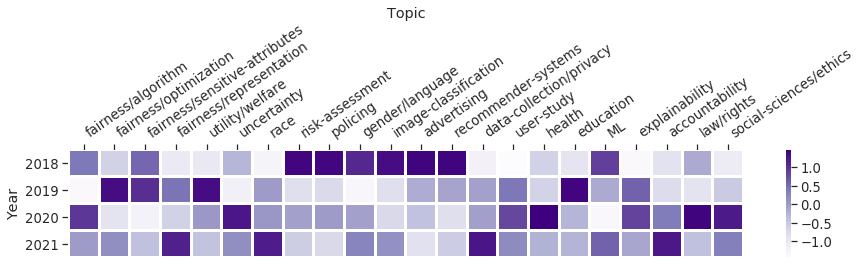

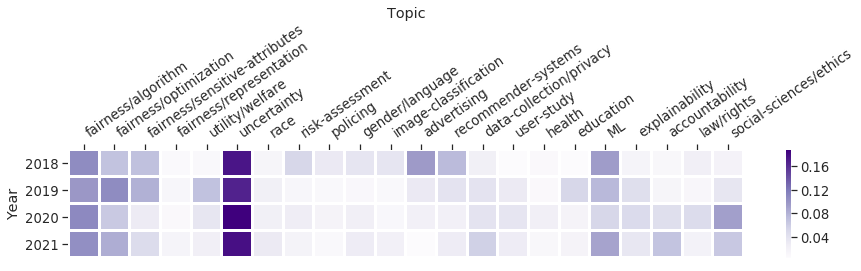

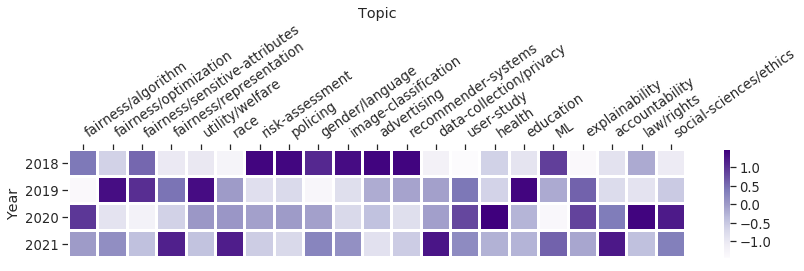

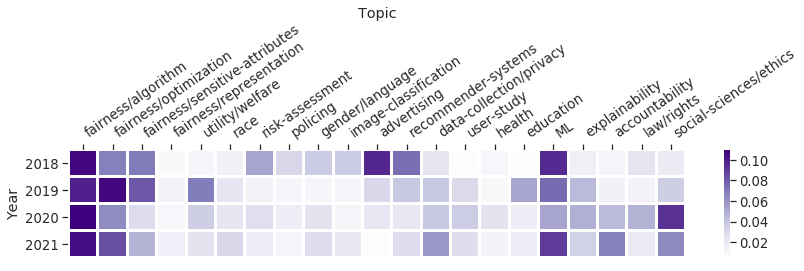

In [294]:
plot_years_by_topics_heatmap(training_years,
                             topic_distributions,
                             topic_keys_edited, 
                             output_directory_path + '/years_by_topics_norm',
                             dim=(13,4))

plot_years_by_topics_heatmap(training_years,
                             topic_distributions,
                             topic_keys_edited, 
                             output_directory_path + '/years_by_topics_unnorm',
                             dim=(13,4),
                             norm = False)

plot_years_by_topics_heatmap(training_years,
                             topic_distributions,
                             topic_keys_edited, 
                             output_directory_path + '/years_by_topics_norm_without_uncertainty',
                             dim=(12,4),
                             remove_uncertainty=True)

plot_years_by_topics_heatmap(training_years,
                             topic_distributions,
                             topic_keys_edited, 
                             output_directory_path + '/years_by_topics_unnorm_without_uncertainty',
                             dim=(12,4),
                             norm = False,
                             remove_uncertainty=True)

In [284]:
# get a sense of fairness in relation to everything else; so unnormalized, remove uncertainty column
# also see what it looks like to remove ML column

fairness_topics = ['fairness/algorithm', 'fairness/optimization', 
                   'fairness/sensitive-attributes', 'fairness/representation']

fair_label = 'fairness'

fair_topics_order = ['fairness', 'utility/welfare',
                     'race', 'risk-assessment', 'policing', 'gender/language', 'image-classification',
                     'advertising', 'recommender-systems', 'data-collection/privacy', 'user-study',
                     'health', 'education', 'ML','explainability', 'accountability', 'law/rights', 
                     'social-sciences/ethics']

fair_topics_order_no_ml = ['fairness', 'utility/welfare',
                     'race', 'risk-assessment', 'policing', 'gender/language', 'image-classification',
                     'advertising', 'recommender-systems', 'data-collection/privacy', 'user-study',
                     'health', 'education', 'explainability', 'accountability', 'law/rights', 
                     'social-sciences/ethics']

def plot_years_by_topics_heatmap_combine_fairness(labels, 
                                                  topic_distributions, 
                                                  topic_keys, 
                                                  output_path=None,
                                                  target_labels=None,
                                                  dim=None,
                                                  remove_ml=False):
    
    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        for _topic_index, _probability in enumerate(_distribution):
            # logic to filter out topics (the "uncertainty" topic is just general words; "ML" common to everything)
            if _topic_index not in [10]:
                # would be more efficient to map cols to a new col in topic_distributions
                # but this is very explicit so whatever, trade-off
                topic = topic_keys[_topic_index]
                if topic in fairness_topics:
                    topic = fair_label

                dicts_to_plot.append({'Probability': float(_probability),
                                      'Year': _label,
                                      'Topic': topic})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    
    df_wide = df_to_plot.pivot_table(index='Year', 
                                     columns='Topic', 
                                     values='Probability')
    
    #df_norm_col=(df_wide-df_wide.mean())/df_wide.std()
    
    if remove_ml:
        df_ordered = df_wide.reindex(columns=fair_topics_order_no_ml)
    else:    
        df_ordered = df_wide.reindex(columns=fair_topics_order)
    

    # remove topics that overpower the others
    # print(df_to_plot)
    df_ordered.to_csv(output_path + ".csv")
    
    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_ordered, cmap='Purples', linewidths=2)    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=35, ha='left')
    plt.yticks(rotation=0)
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path + ".pdf")
    plt.show()

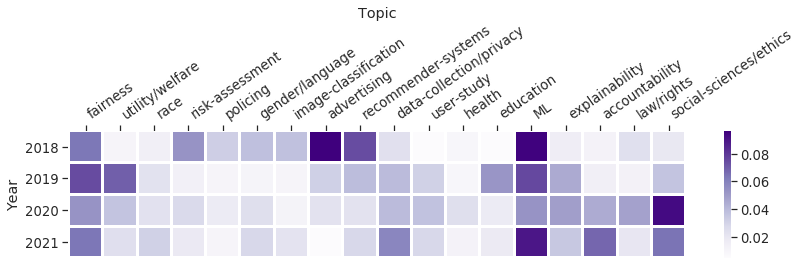

In [295]:
plot_years_by_topics_heatmap_combine_fairness(training_years,
                                              topic_distributions,
                                              topic_keys_edited, 
                                              output_directory_path + '/years_by_topics_combine_fair_unnorm_remove_uncertainty',
                                              dim=(12,4))

In [72]:
# create label to year dict
df_all_papers.sample(3)

,ID,Year,FileName,Text
30,2019-16,2019,3287560.3287586.txt,Classification with Fairness Constraints A Met...
41,2019-27,2019,3287560.3287588.txt,Fairness-Aware Programming Increasingly progra...
7,2018-8,2018,kamishima18a,Recommendation Independence This paper studies...


In [288]:
def plot_papers_by_topics_heatmap(labels,
                                  year_string,
                                  topic_distributions, 
                                  topic_keys,
                                  output_path=None,
                                  target_labels=None,
                                  dim=None,
                                  norm=True,
                                  remove_uncertainty=False):
    
    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        year = _label[0:4]
        for _topic_index, _probability in enumerate(_distribution):
            # filter label by year
            if year == year_string:
                dicts_to_plot.append({'Probability': float(_probability),
                                      'PaperID': _label,
                                      'Topic': topic_keys[_topic_index]})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    
    df_wide = df_to_plot.pivot_table(index='PaperID', 
                                     columns='Topic', 
                                     values='Probability')
    to_plot = df_wide
    if norm:
        to_plot = (df_wide-df_wide.mean())/df_wide.std()
    
    if remove_uncertainty:
        df_ordered = to_plot.reindex(columns=topics_ordered_without_uncertainty)
    else:
        df_ordered = to_plot.reindex(columns=topics_order)
   
    # remove topics that overpower the others
    # print(df_norm_ordered)
    df_ordered.to_csv(output_path + ".csv")
    
    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_ordered, cmap='Purples', linewidths=2)    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path + ".pdf")
    plt.show()

In [192]:
df_all_papers[['ID','Year','FileName']].to_csv(output_directory_path + "/paper_ids.csv")

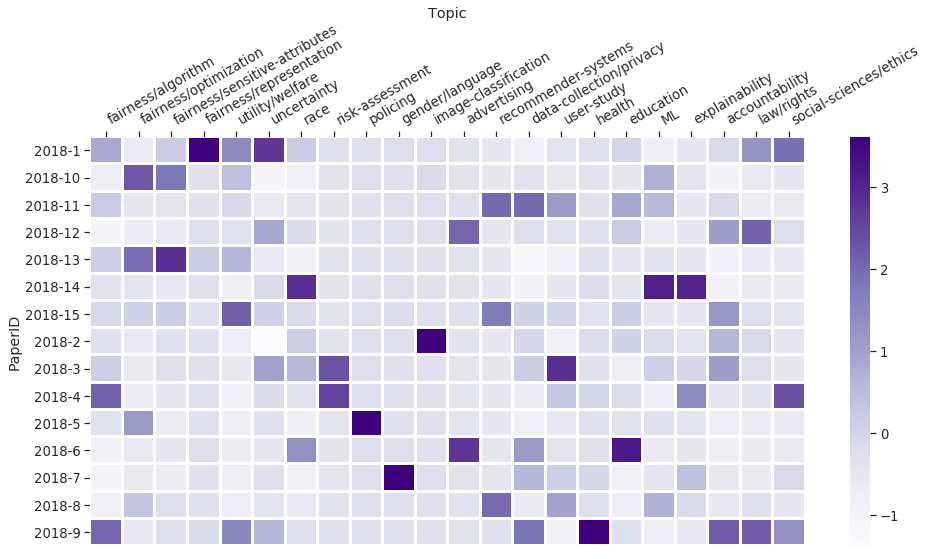

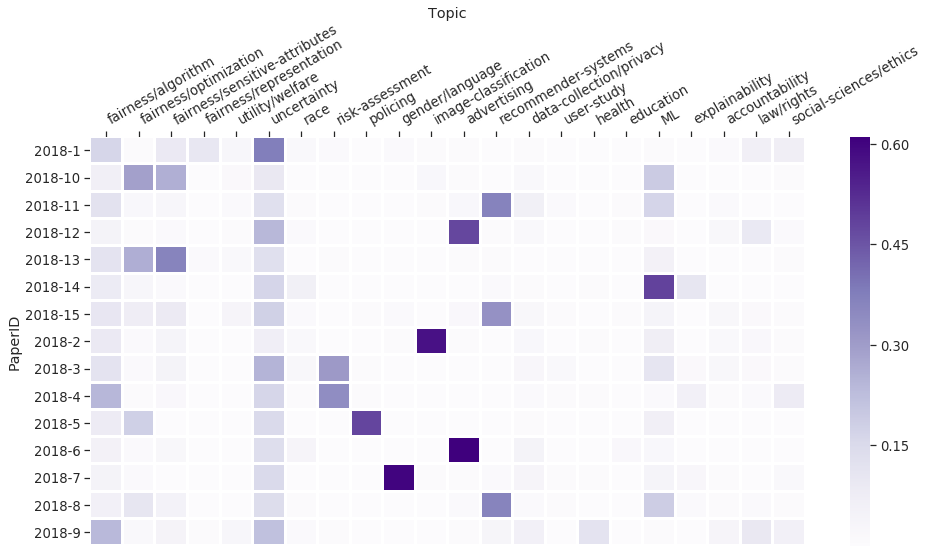

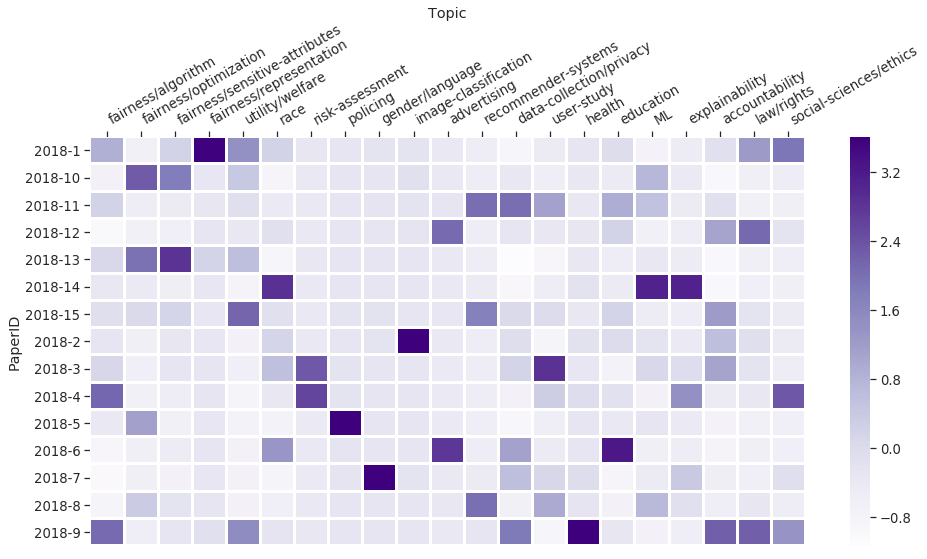

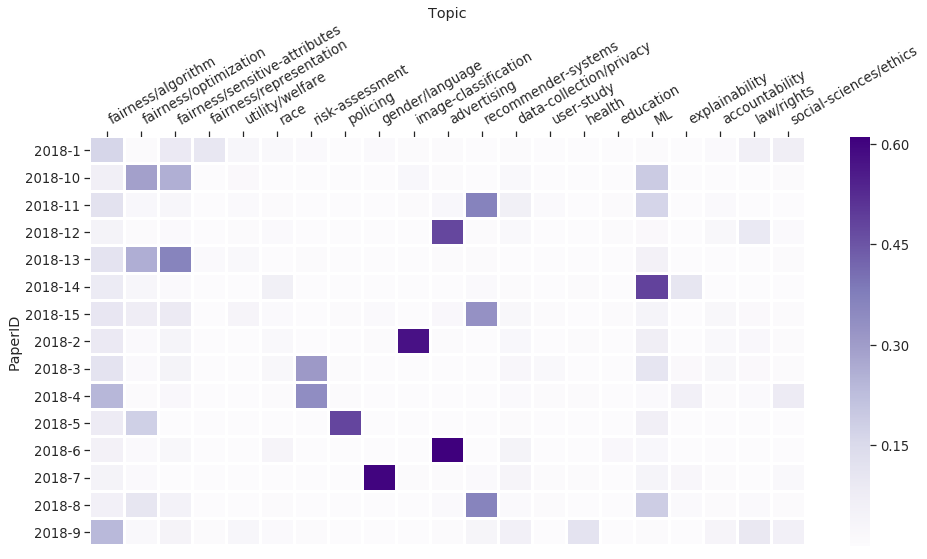

In [289]:
plot_papers_by_topics_heatmap(training_paper_ids,
                              "2018",
                              topic_distributions,
                              topic_keys_edited,
                              output_directory_path + '/papers_by_topics_2018_norm',
                              dim=(14,8))

plot_papers_by_topics_heatmap(training_paper_ids,
                              "2018",
                              topic_distributions,
                              topic_keys_edited,
                              output_directory_path + '/papers_by_topics_2018_unnorm',
                              dim=(14,8),
                              norm=False)

plot_papers_by_topics_heatmap(training_paper_ids,
                              "2018",
                              topic_distributions,
                              topic_keys_edited,
                              output_directory_path + '/papers_by_topics_2018_norm_remove_uncertainty',
                              dim=(14,8),
                              remove_uncertainty=True)

plot_papers_by_topics_heatmap(training_paper_ids,
                              "2018",
                              topic_distributions,
                              topic_keys_edited,
                              output_directory_path + '/papers_by_topics_2018_unnorm_remove_uncertainty',
                              dim=(14,8),
                              norm=False,
                              remove_uncertainty=True)

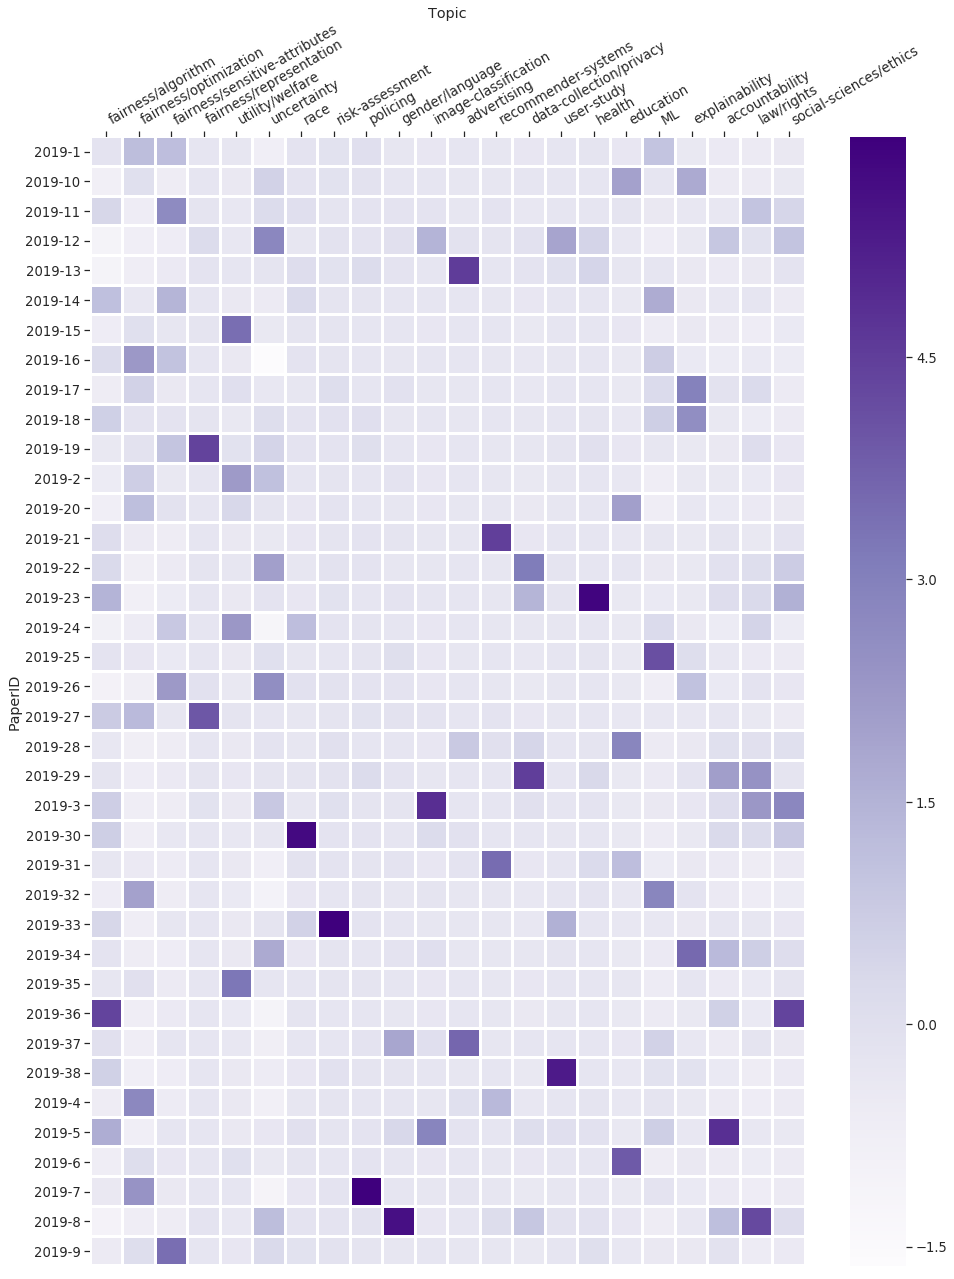

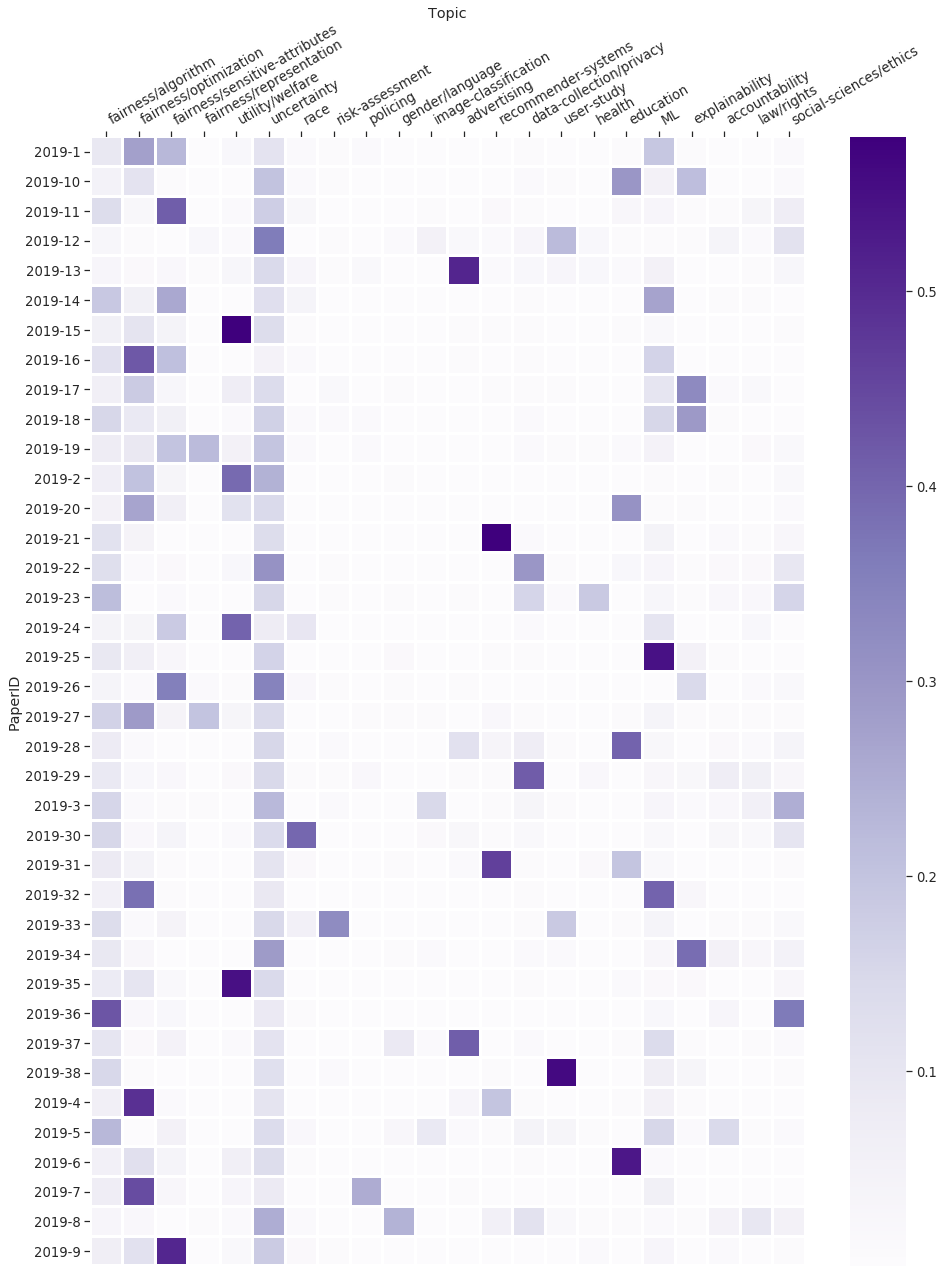

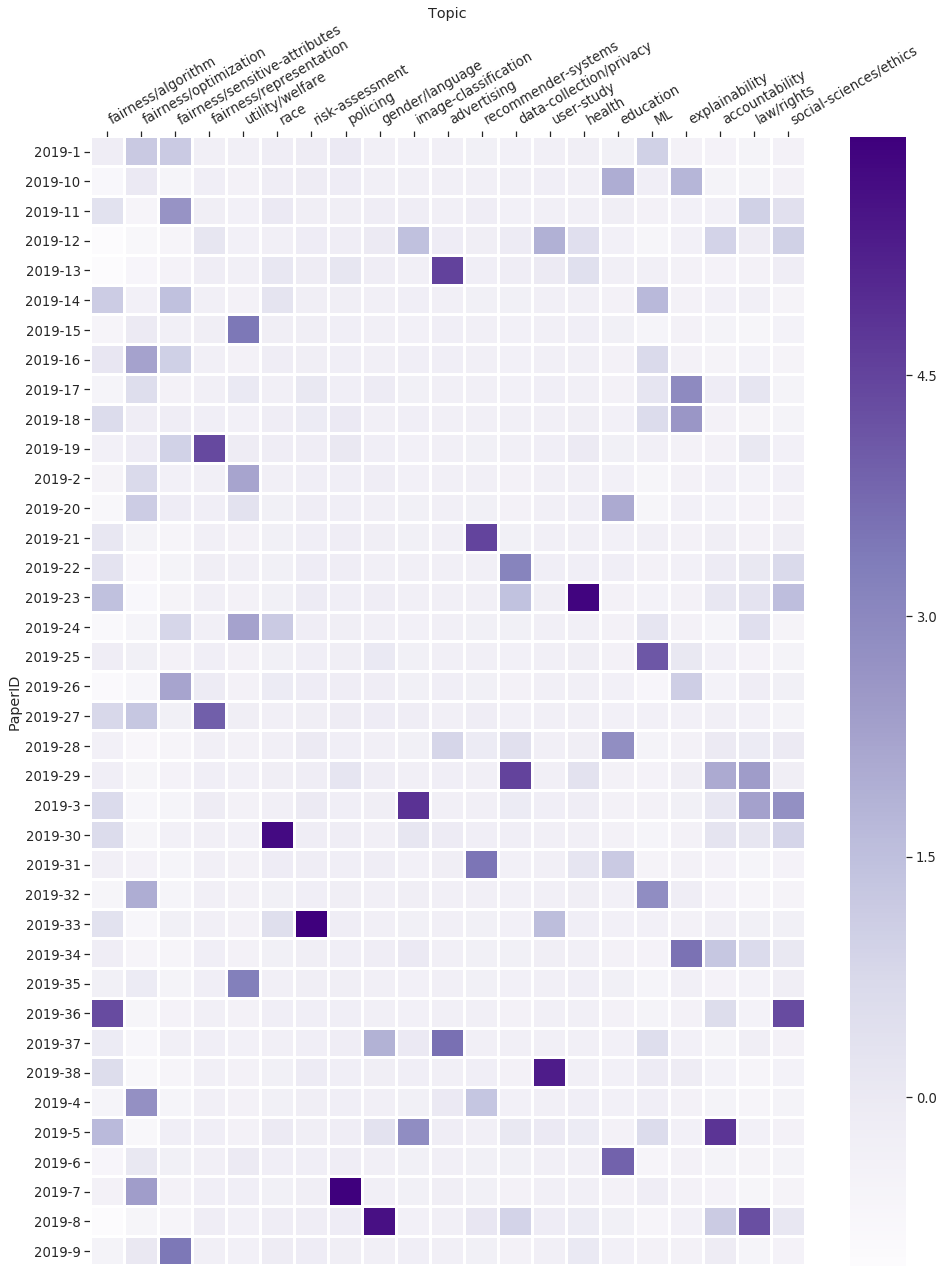

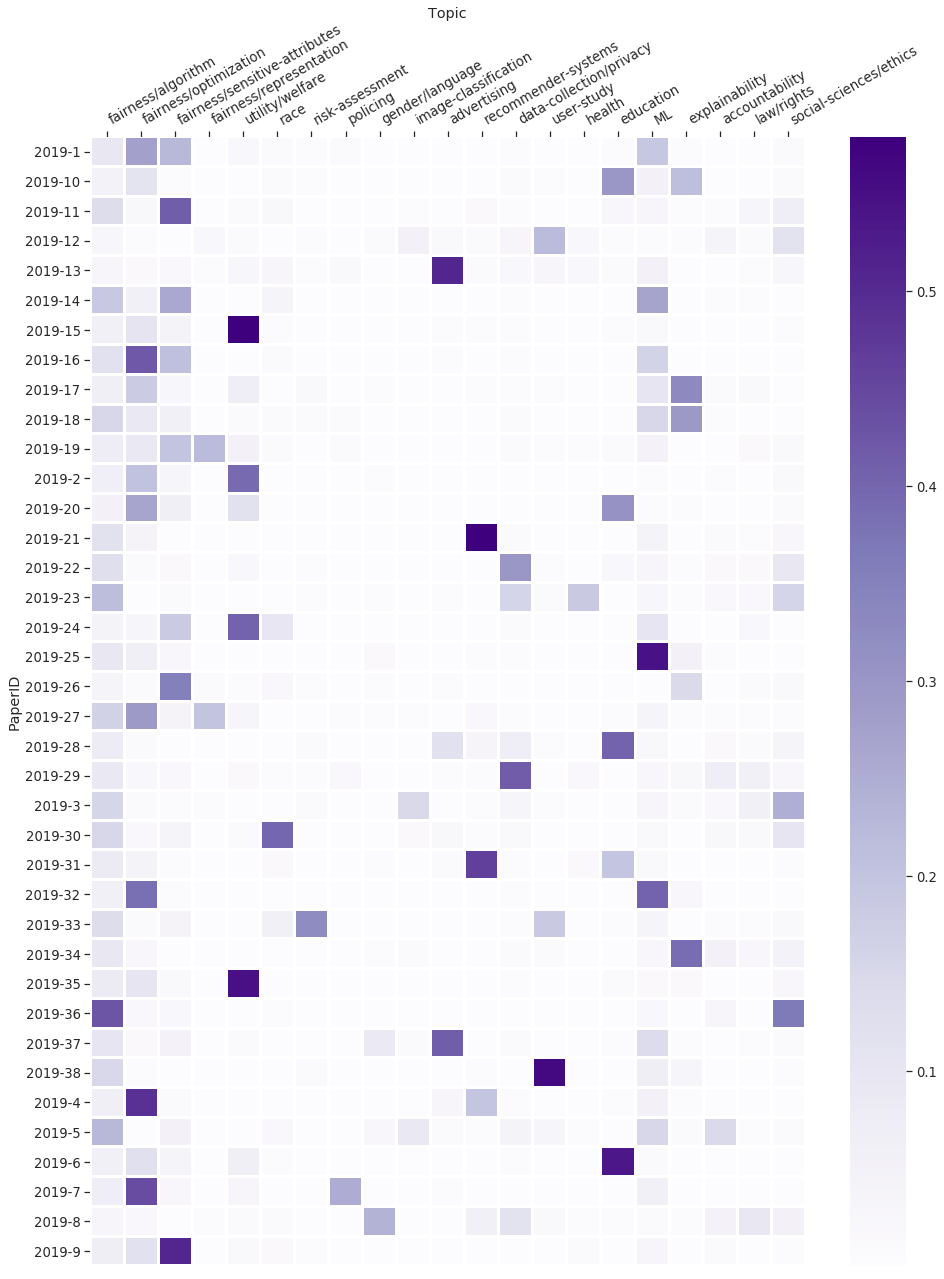

In [290]:
plot_papers_by_topics_heatmap(training_paper_ids,
                              "2019",
                              topic_distributions,
                              topic_keys_edited,
                              output_directory_path + '/papers_by_topics_2019_norm',
                              dim=(14,18))

plot_papers_by_topics_heatmap(training_paper_ids,
                              "2019",
                              topic_distributions,
                              topic_keys_edited,
                              output_directory_path + '/papers_by_topics_2019_unnorm',
                              dim=(14,18),
                              norm=False)

plot_papers_by_topics_heatmap(training_paper_ids,
                              "2019",
                              topic_distributions,
                              topic_keys_edited,
                              output_directory_path + '/papers_by_topics_2019_norm_remove_uncertainty',
                              dim=(14,18),
                              remove_uncertainty=True)

plot_papers_by_topics_heatmap(training_paper_ids,
                              "2019",
                              topic_distributions,
                              topic_keys_edited,
                              output_directory_path + '/papers_by_topics_2019_unnorm_remove_uncertainty',
                              dim=(14,18),
                              norm=False,
                              remove_uncertainty=True)

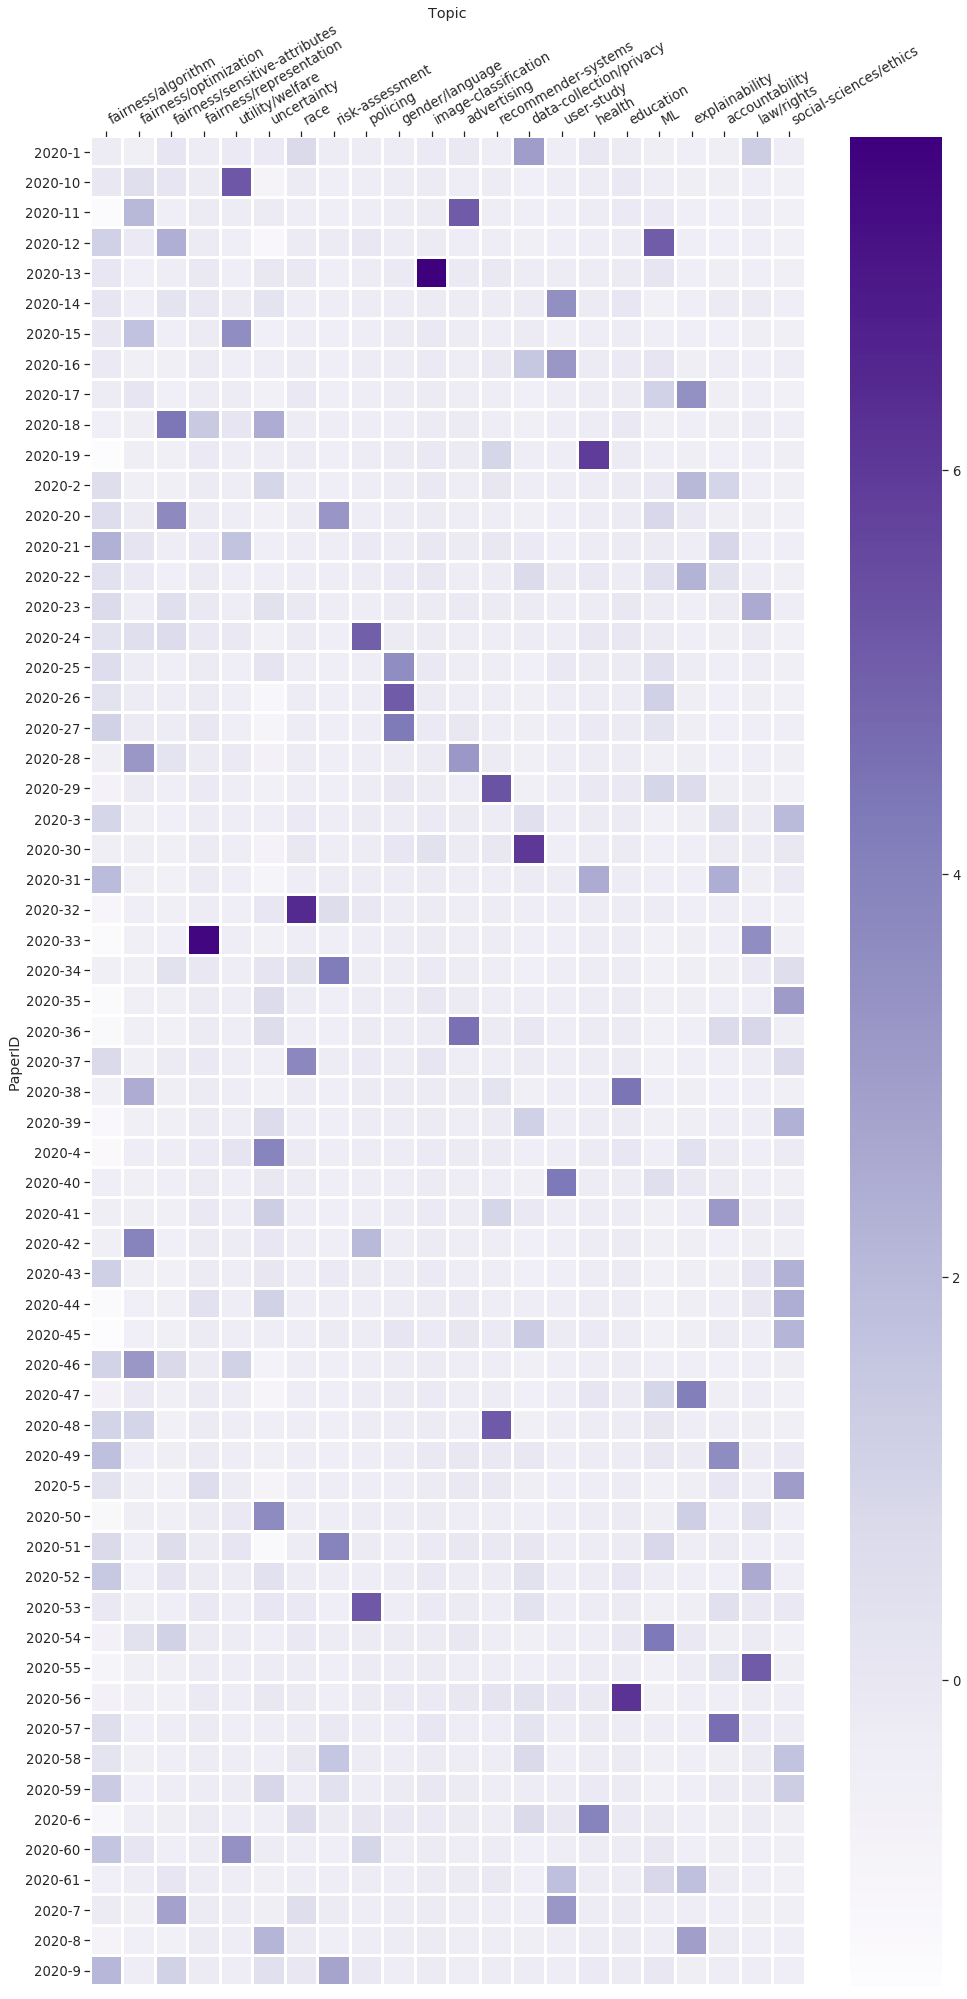

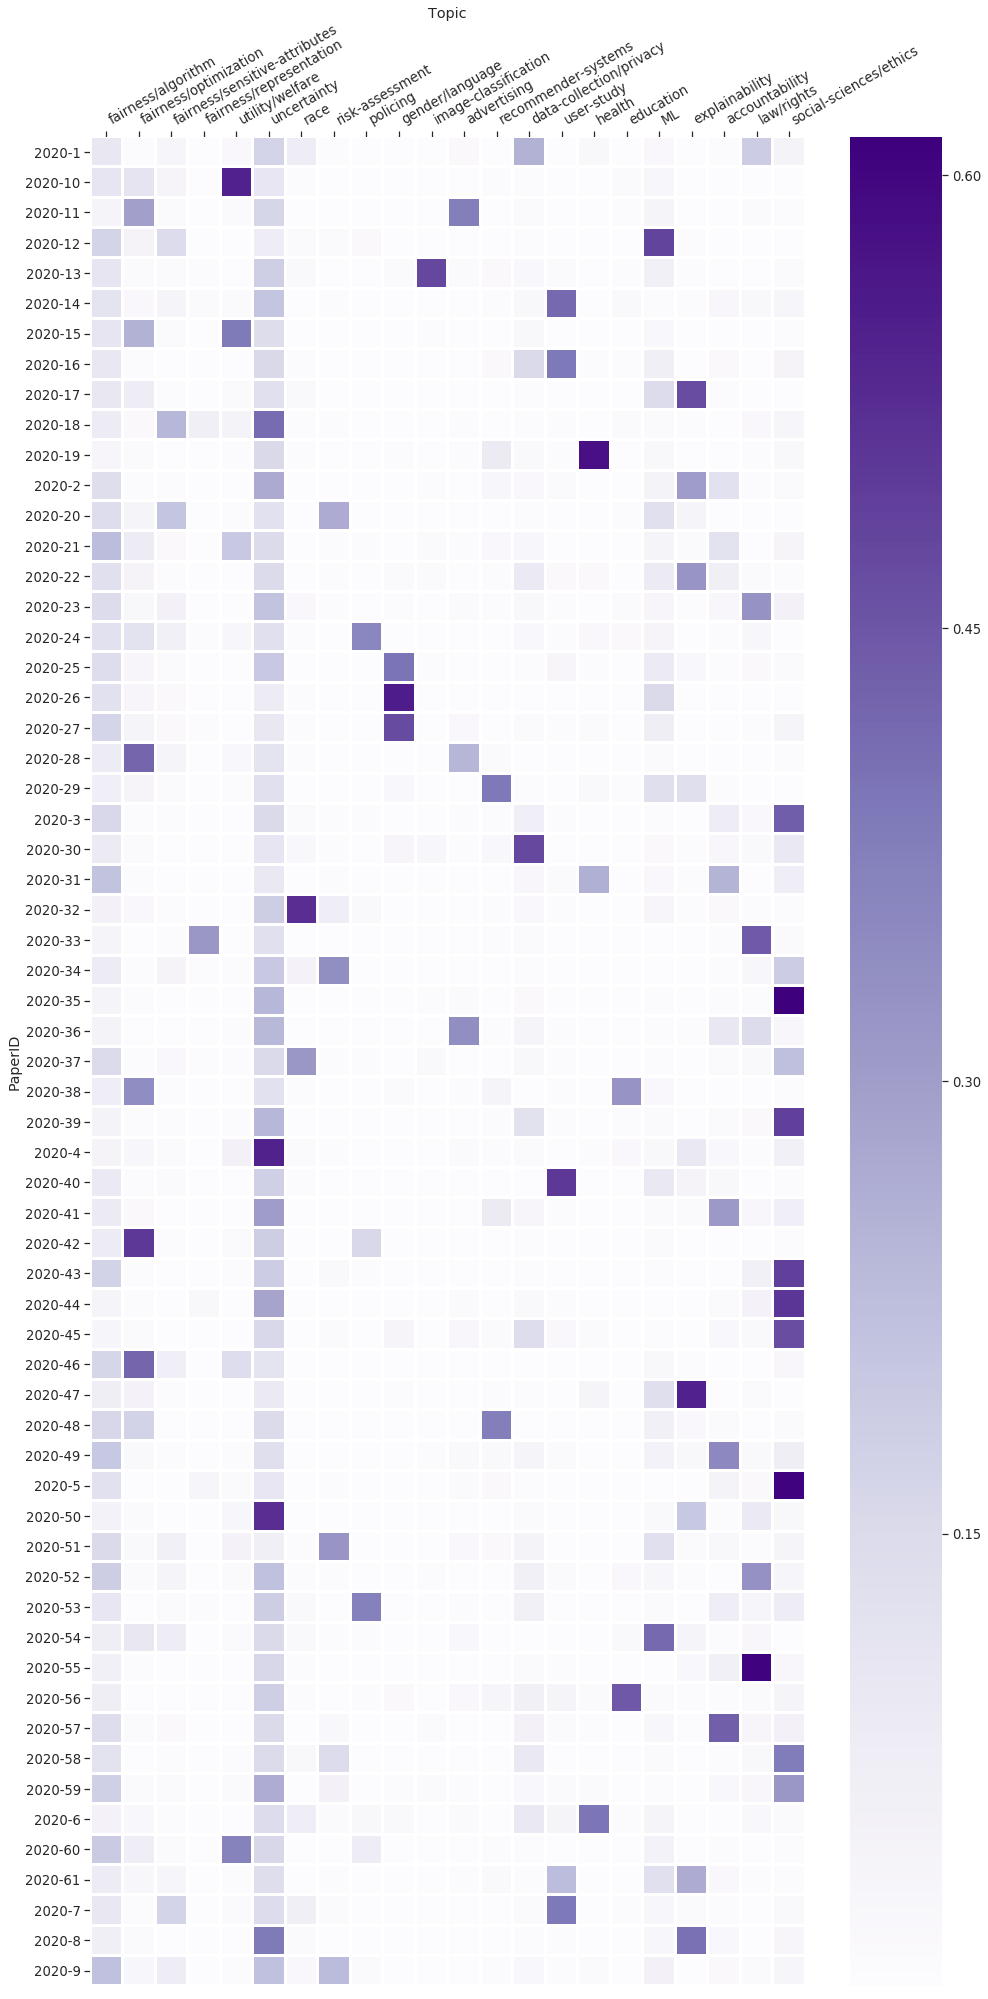

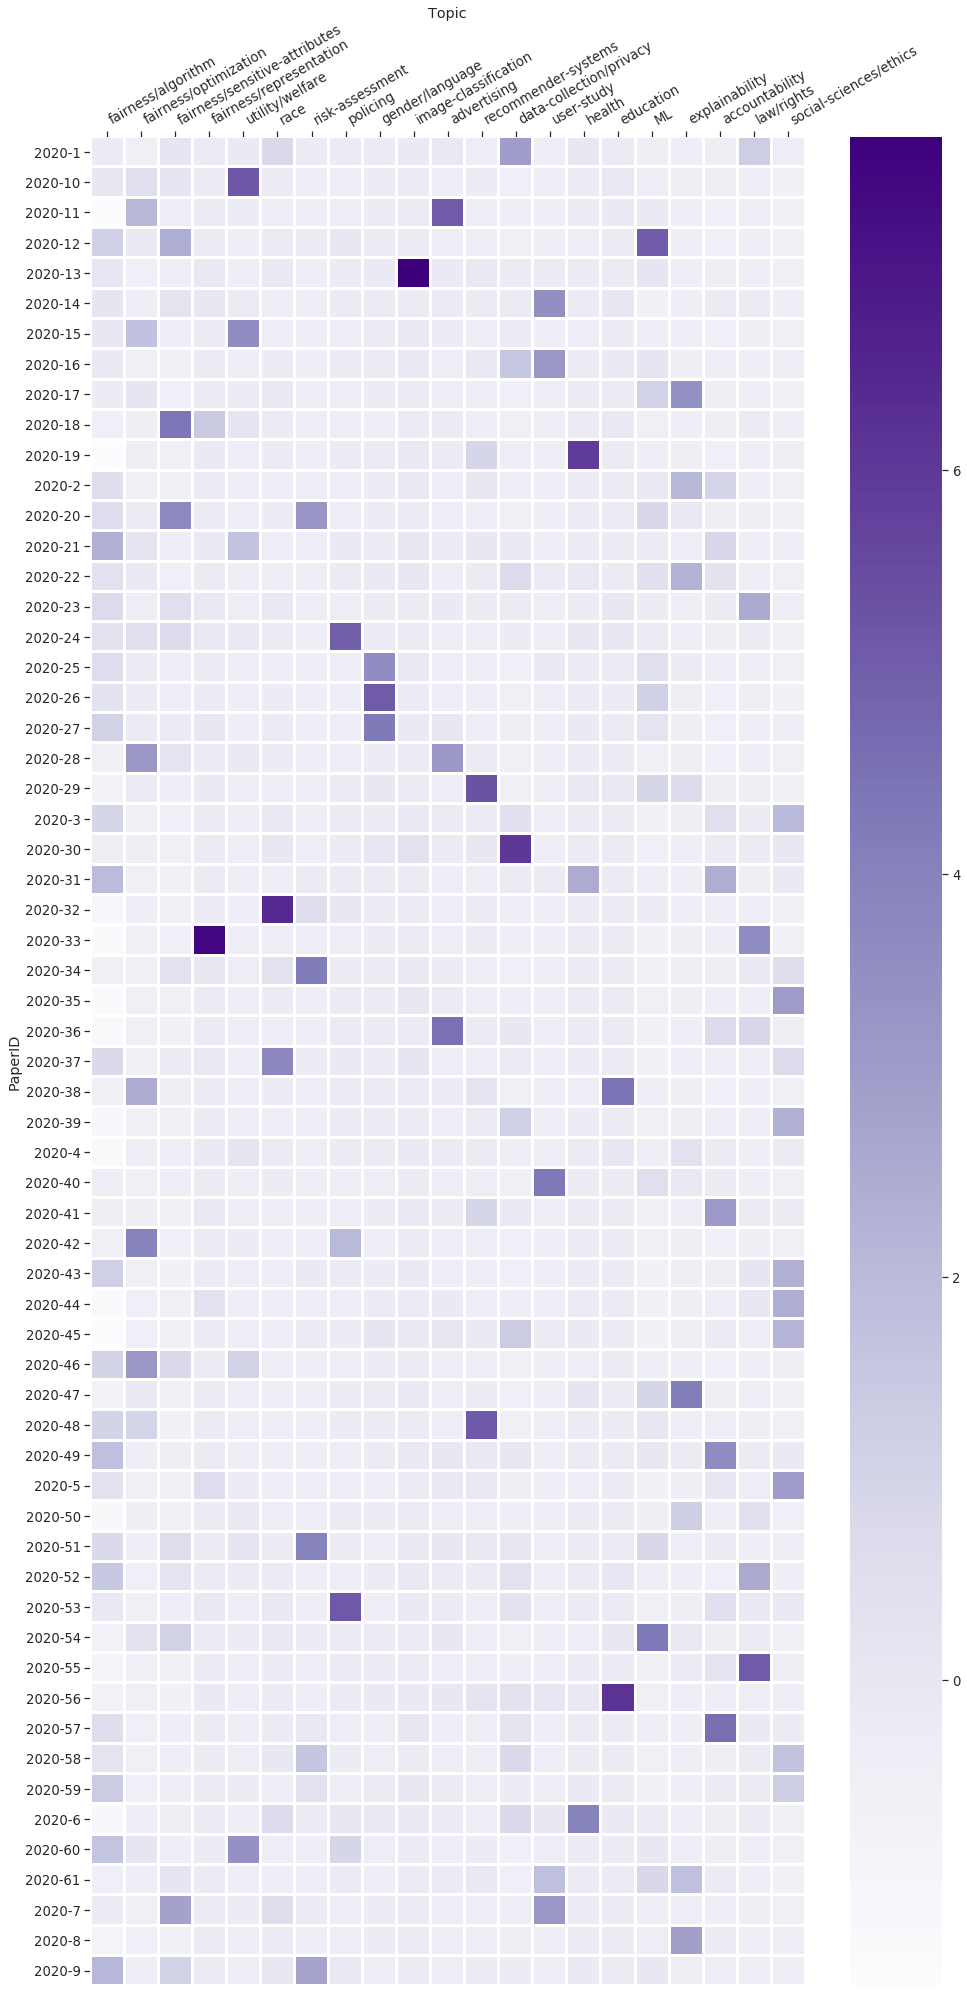

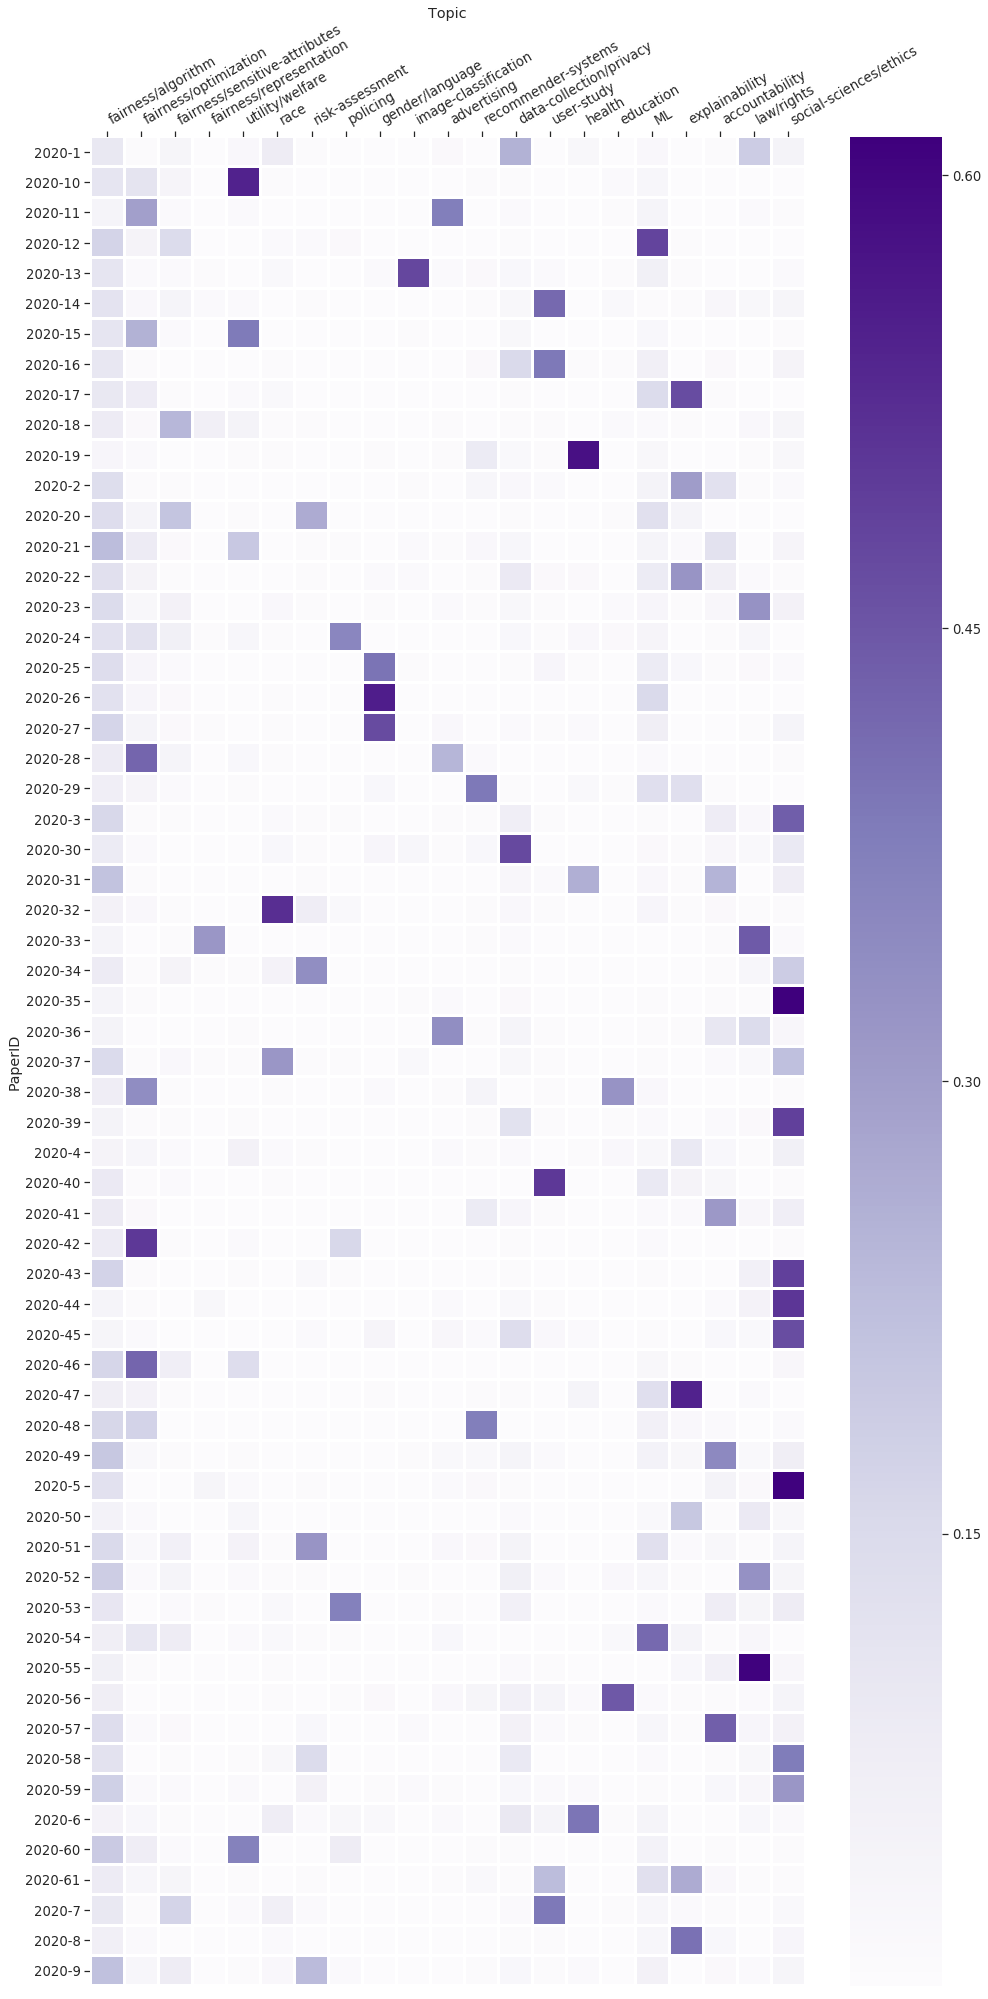

In [291]:
plot_papers_by_topics_heatmap(training_paper_ids,
                              "2020",
                              topic_distributions,
                              topic_keys_edited,
                              output_directory_path + '/papers_by_topics_2020_norm',
                              dim=(14,28))

plot_papers_by_topics_heatmap(training_paper_ids,
                              "2020",
                              topic_distributions,
                              topic_keys_edited,
                              output_directory_path + '/papers_by_topics_2020_unnorm',
                              dim=(14,28),
                              norm=False)

plot_papers_by_topics_heatmap(training_paper_ids,
                              "2020",
                              topic_distributions,
                              topic_keys_edited,
                              output_directory_path + '/papers_by_topics_2020_norm_remove_uncertainty',
                              dim=(14,28),
                              remove_uncertainty=True)

plot_papers_by_topics_heatmap(training_paper_ids,
                              "2020",
                              topic_distributions,
                              topic_keys_edited,
                              output_directory_path + '/papers_by_topics_2020_unnorm_remove_uncertainty',
                              dim=(14,28),
                              norm=False,
                              remove_uncertainty=True)

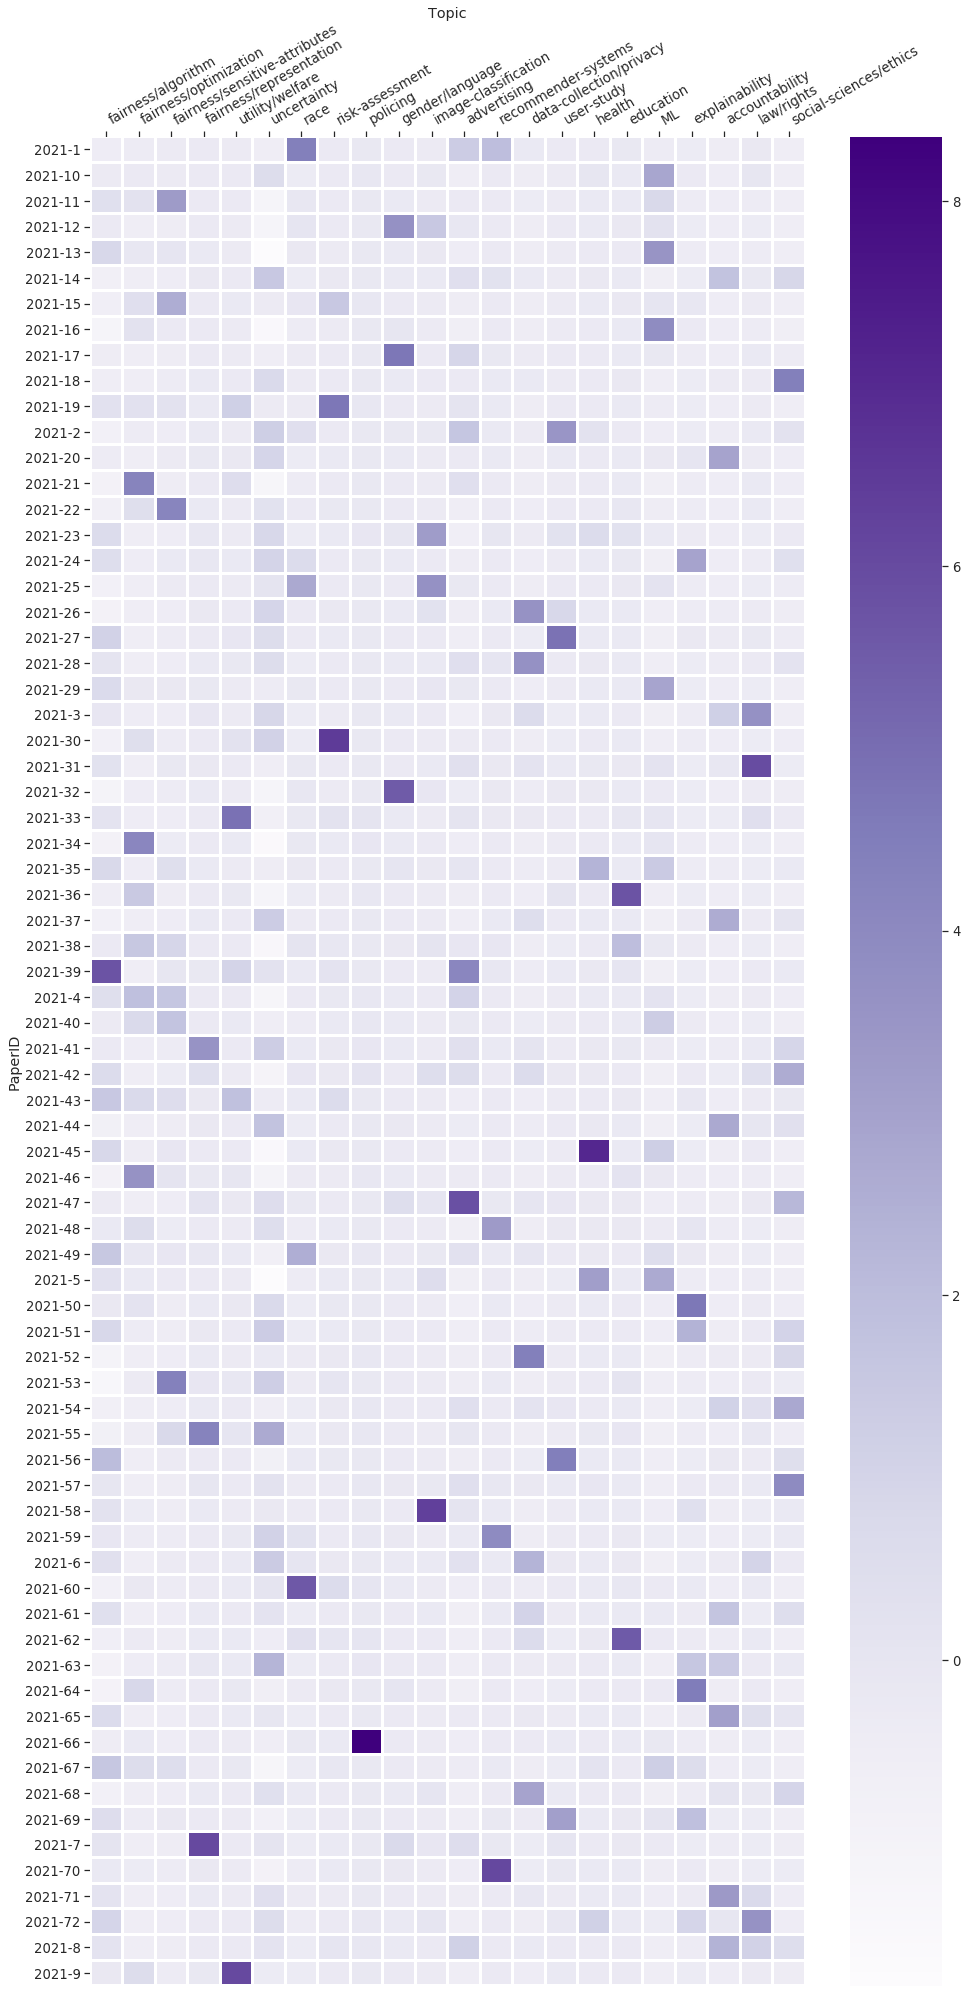

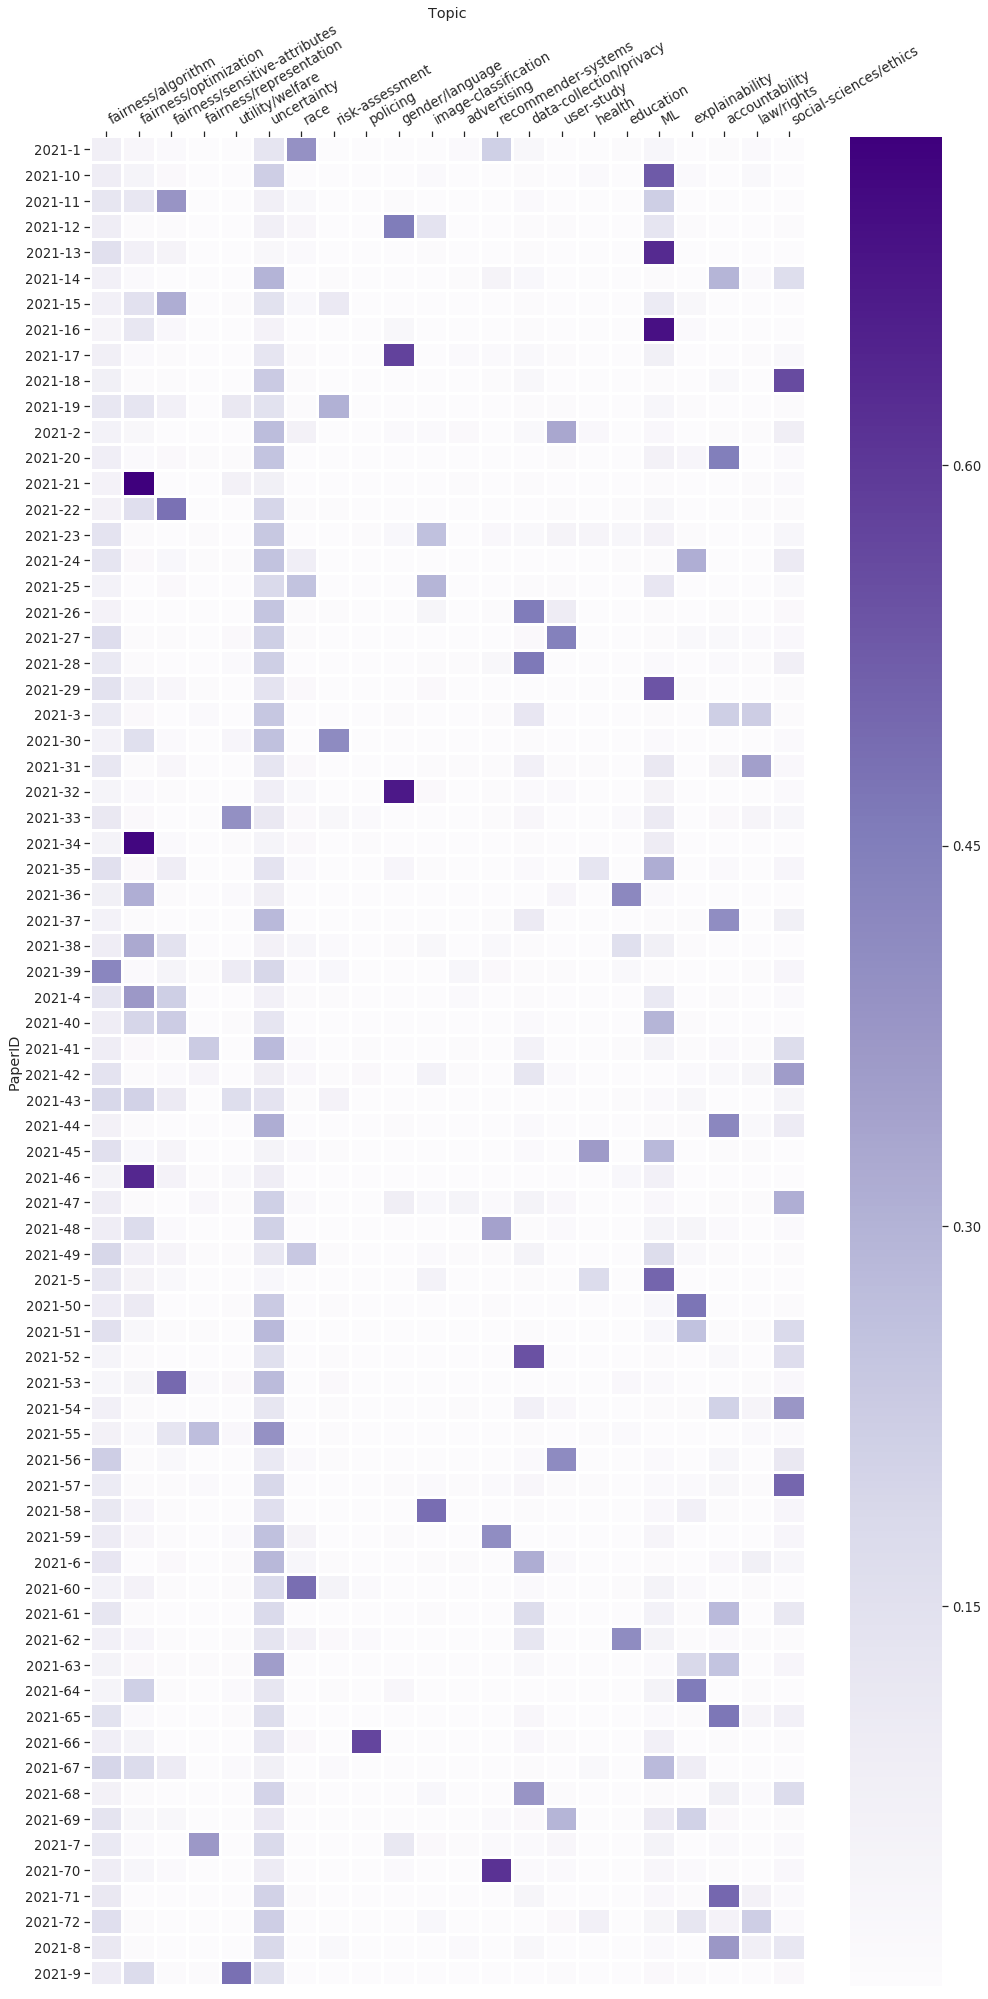

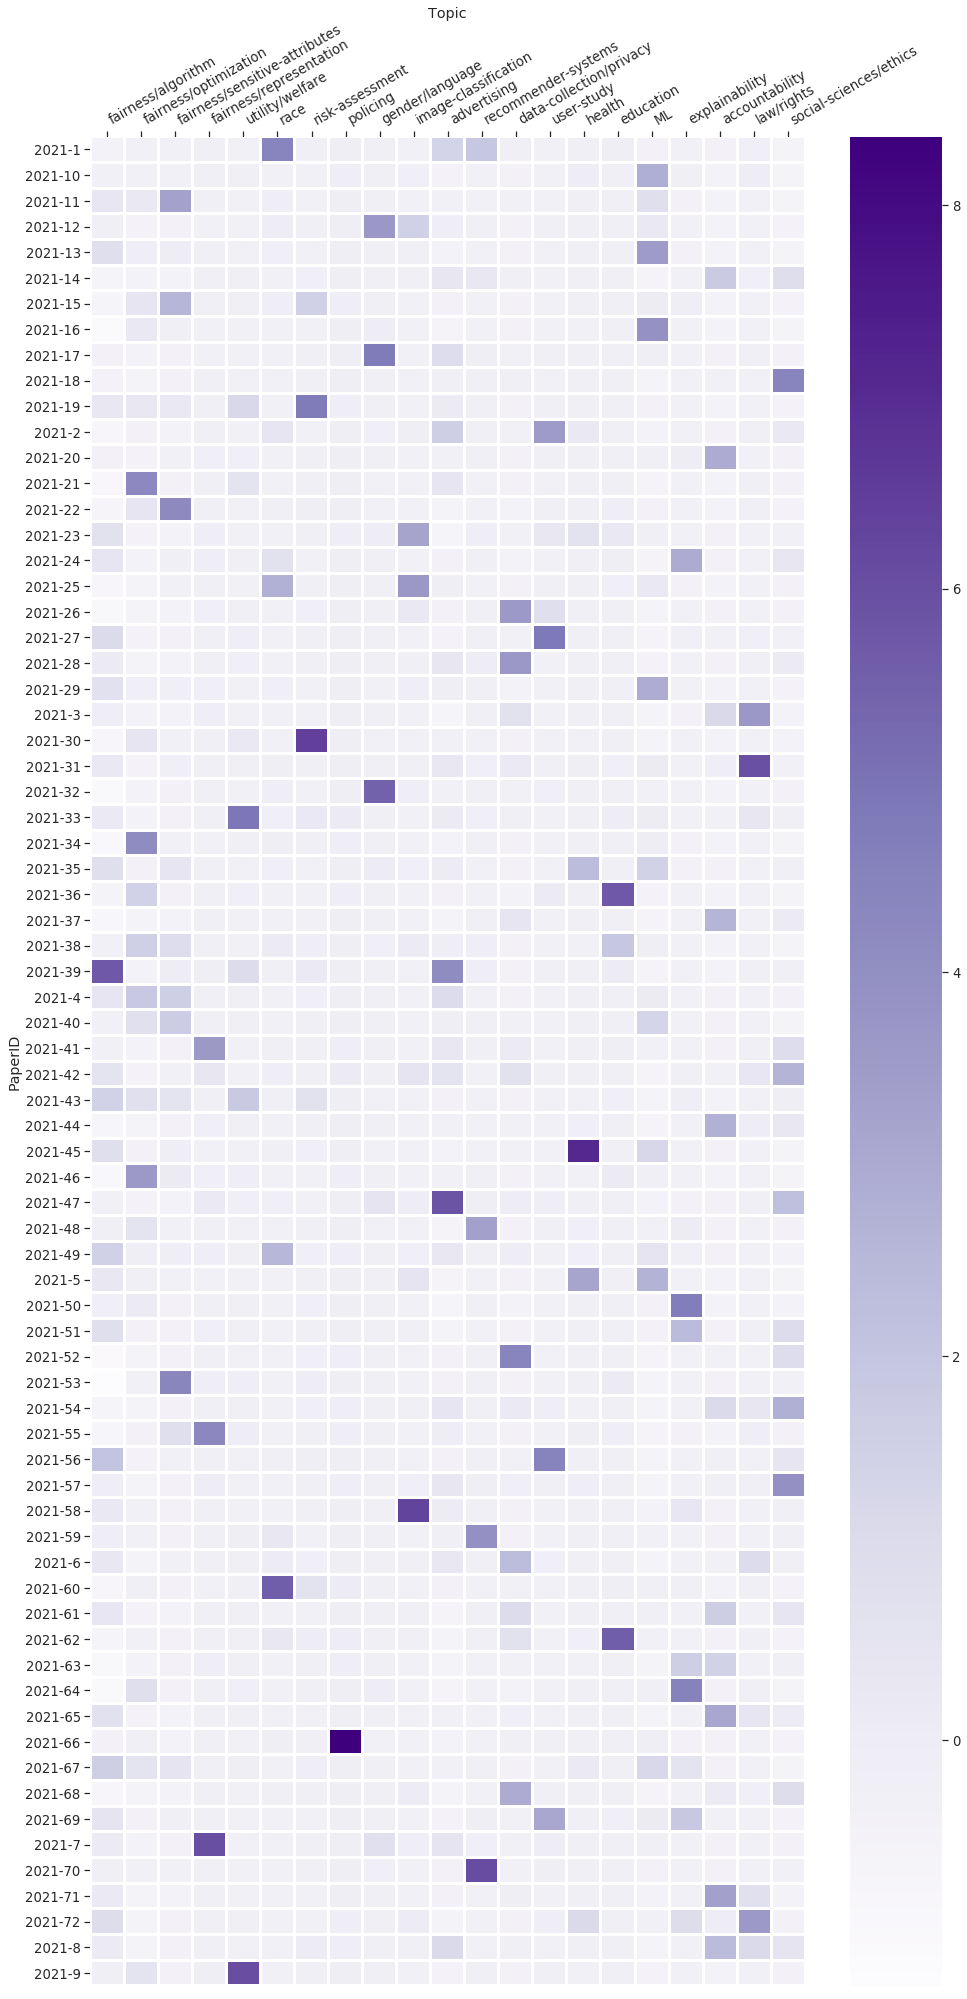

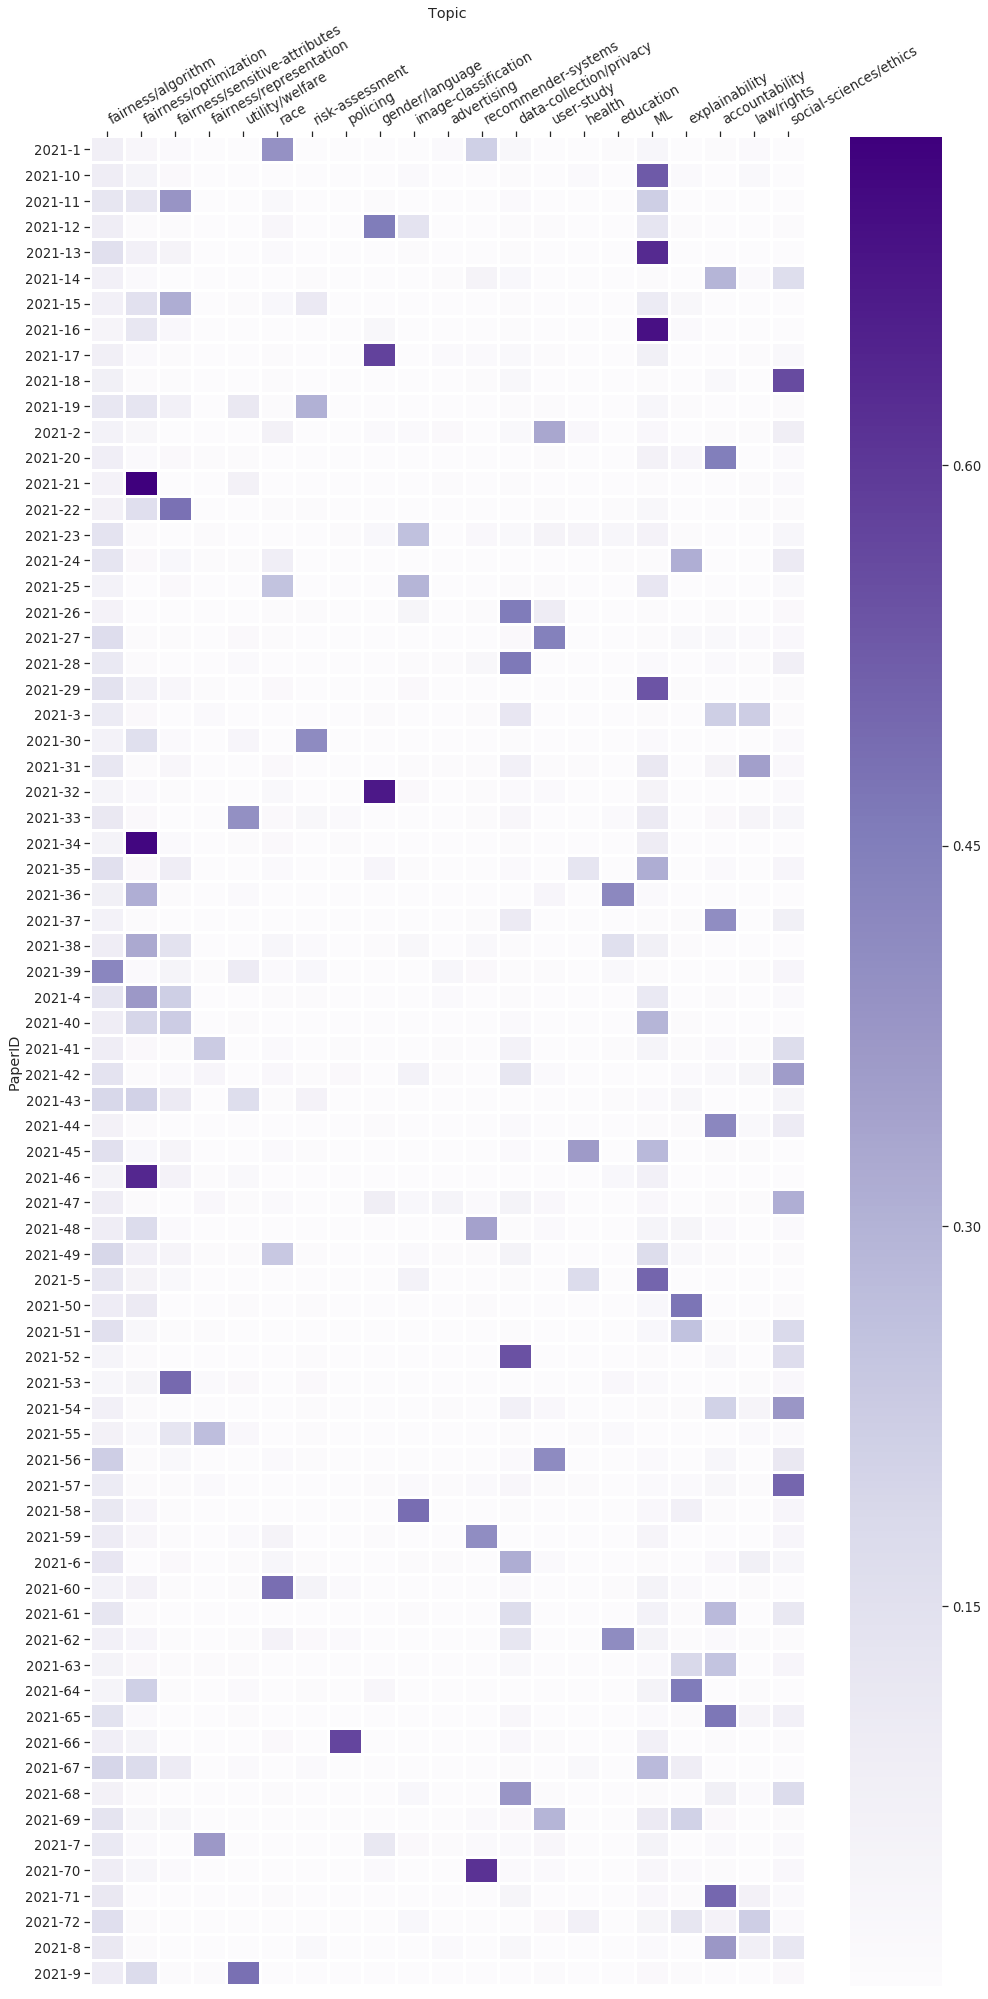

In [292]:
plot_papers_by_topics_heatmap(training_paper_ids,
                              "2021",
                              topic_distributions,
                              topic_keys_edited,
                              output_directory_path + '/papers_by_topics_2021_norm',
                              dim=(14,28))

plot_papers_by_topics_heatmap(training_paper_ids,
                              "2021",
                              topic_distributions,
                              topic_keys_edited,
                              output_directory_path + '/papers_by_topics_2021_unnorm',
                              dim=(14,28),
                              norm=False)

plot_papers_by_topics_heatmap(training_paper_ids,
                              "2021",
                              topic_distributions,
                              topic_keys_edited,
                              output_directory_path + '/papers_by_topics_2021_norm_remove_uncertainty',
                              dim=(14,28),
                              remove_uncertainty=True)

plot_papers_by_topics_heatmap(training_paper_ids,
                              "2021",
                              topic_distributions,
                              topic_keys_edited,
                              output_directory_path + '/papers_by_topics_2021_unnorm_remove_uncertainty',
                              dim=(14,28),
                              norm=False,
                              remove_uncertainty=True)

In [198]:
lmw.print_dataset_stats(training_texts)

Number of Documents: 7149
Mean Number of Words per Document: 117.2
Vocabulary Size: 23764


22
